# 🦟 Predição de Hospitalização por Dengue - Modelo Final

---

## 📋 RESUMO EXECUTIVO

### 🎯 Objetivo

Desenvolver um modelo de machine learning capaz de **predizer a probabilidade de hospitalização** de pacientes com dengue com base em:

- ✅ **Características Demográficas**: Idade, Sexo, Raça
- ✅ **Sintomas Clínicos**: Febre, Mialgia, Cefaleia, Vômito, Exantema (5 principais da OMS)
- ✅ **Condições Climáticas**: Fenômenos climáticos (El Niño/La Niña), Intensidade, Sazonalidade (Mês)

---

### 🔧 Metodologia

| Aspecto | Configuração |
|---------|-------------|
| **Algoritmo Principal** | Regressão Logística |
| **Comparação** | Random Forest, XGBoost, CatBoost |
| **Dataset** | 26.449 registros (após limpeza) |
| **Features Core** | 5 sintomas principais + demográficas + climáticas |
| **Feature Selection** | Automática (Feature Importance + Análises Estatísticas) |
| **Otimização** | **Optuna** (Hyperparameter Tuning) |
| **Pré-processamento** | One-Hot Encoding, Normalização (StandardScaler), Balanceamento (SMOTE) |
| **Validação** | Train/Test Split 80/20, Estratificação, `random_state=42` |
| **Métrica Prioritária** | **Recall (Sensitivity)** ≥ 0.85 (minimizar falsos negativos) |

---

### 📊 Features Utilizadas

#### **1. Sintomas Clínicos (5 principais OMS)**
- FEBRE_BIN
- MIALGIA_BIN
- CEFALEIA_BIN
- VOMITO_BIN
- EXANTEMA_BIN

#### **2. Características Demográficas**
- IDADE
- SEXO_BIN (M/F)
- RACA_* (One-Hot Encoding)

#### **3. Condições Climáticas**
- FENOMENO_BIN (El Niño/La Niña)
- INTENS_FENOM_BIN (Intensidade)
- MES (Sazonalidade 1-12)
- TRIMESTRE (1-4)

#### **4. Features Engineered**
- SINTOMAS_SCORE (soma dos 5 sintomas)
- COMORBIDADE_SCORE (diabetes, hematológico, hepático, renal)
- TEM_COMORBIDADE (binário)
- DIAS_SINTOMA_NOTIFIC (tempo até notificação)

---

### 🎯 Pipeline de Desenvolvimento

```
1. Carregamento e Limpeza de Dados
   ↓ (Remover casos "IGNORADO")

2. Feature Engineering Completo
   ↓ (Demográficas + Clínicas + Climáticas)

3. Train/Test Split (80/20)
   ↓ (Estratificado, random_state=42)

4. Modelos Baseline
   ↓ (Para Feature Importance)

5. Feature Selection Automática
   ↓ (Importância + Correlação + Chi²)

6. Tunagem com Optuna
   ↓ (Otimizar hiperparâmetros)

7. Treinamento Final
   ↓ (Com features otimizadas + hiperparâmetros otimizados)

8. Avaliação Clínica
   ↓ (Recall, NPV, ROC-AUC)

9. Interpretabilidade (SHAP)
   ↓ (Explicar decisões)

10. Deploy
    ↓ (Salvar modelo, scaler, features)
```

---

### 🏆 Resultados Esperados

- ✅ **Recall (Sensitivity)** ≥ 0.85 (detectar 85%+ dos casos graves)
- ✅ **NPV (Negative Predictive Value)** ≥ 0.95 (confiança em resultados negativos)
- ✅ **ROC-AUC** ≥ 0.70 (discriminação razoável)
- ✅ **Interpretabilidade** com SHAP (explicar cada predição)

---

### 📁 Artefatos Gerados

- `modelo_reglog_otimizado.pkl` - Modelo treinado
- `scaler_final.pkl` - Scaler para normalização
- `features_selecionadas.txt` - Lista de features
- `config_modelo.json` - Configuração completa
- `optuna_study.db` - Histórico de otimização
- Gráficos de avaliação (ROC, PR, Feature Importance, SHAP)

---

**🏥 Healthcare ML: Em saúde, Recall > tudo. Melhor errar por excesso de cuidado!**

---

## 📦 1. IMPORTS E CONFIGURAÇÕES

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, recall_score, precision_score, f1_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, mutual_info_classif
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Hyperparameter Tuning
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Interpretability
import shap

# Utils
import warnings
warnings.filterwarnings('ignore')
import joblib
import json

# Config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Bibliotecas importadas!")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n📦 Versões:")
print(f"   Pandas: {pd.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Optuna: {optuna.__version__}")

✅ Bibliotecas importadas!
📅 2025-11-15 13:24:02

📦 Versões:
   Pandas: 2.3.3
   NumPy: 2.3.4
   Optuna: 4.6.0


## 📊 2. CARREGAMENTO E LIMPEZA DE DADOS

In [2]:
# Carregar dataset
df = pd.read_csv('df_dengue_tratado.csv')

print("="*80)
print("📊 DATASET ORIGINAL")
print("="*80)
print(f"\n📏 Dimensões: {df.shape[0]:,} registros x {df.shape[1]} colunas")
print(f"\n🎯 Distribuição HOSPITALIZ:")
print(df['HOSPITALIZ'].value_counts())
print(f"\n📊 Desbalanceamento: {(df['HOSPITALIZ']=='SIM').sum()/len(df)*100:.2f}% hospitalizações")

# Verificar colunas climáticas
print(f"\n🌡️ Colunas Climáticas Disponíveis:")
print(f"   - FENOMENO: {df['FENOMENO'].unique()[:5]}")
print(f"   - INTENS_FENOM: {df['INTENS_FENOM'].unique()[:5]}")

📊 DATASET ORIGINAL

📏 Dimensões: 33,319 registros x 31 colunas

🎯 Distribuição HOSPITALIZ:
HOSPITALIZ
NÃO         26059
IGNORADO     6870
SIM           390
Name: count, dtype: int64

📊 Desbalanceamento: 1.17% hospitalizações

🌡️ Colunas Climáticas Disponíveis:
   - FENOMENO: ['Neutro' 'La Niña' 'El Niño']
   - INTENS_FENOM: ['NEUTRA' 'MODERADA' 'FRACA' 'FORTE' 'MUITO FORTE']


In [3]:
# LIMPEZA: Remover casos "IGNORADO"
print("\n" + "="*80)
print("🧹 LIMPEZA DE DADOS")
print("="*80)

print(f"\n📊 ANTES DA LIMPEZA:")
print(f"   Total: {len(df):,} registros")
print(f"   Casos 'IGNORADO': {(df['HOSPITALIZ']=='IGNORADO').sum():,} ({(df['HOSPITALIZ']=='IGNORADO').sum()/len(df)*100:.1f}%)")

# Remover IGNORADO
df_clean = df[df['HOSPITALIZ'].isin(['SIM', 'NÃO'])].copy()

print(f"\n✅ DEPOIS DA LIMPEZA:")
print(f"   Total: {len(df_clean):,} registros")
print(f"   Removidos: {len(df) - len(df_clean):,}")
print(f"   Taxa de hospitalização: {(df_clean['HOSPITALIZ']=='SIM').sum()/len(df_clean)*100:.2f}%")

print(f"\n💡 Agora treinamos apenas com dados confiáveis (SIM/NÃO)!")

df = df_clean.copy()
del df_clean

# ==============================================================================
# REMOÇÃO DE OUTLIERS ⭐ NOVO!
# ==============================================================================

print("\n" + "="*80)
print("🧹 REMOÇÃO DE OUTLIERS")
print("="*80)

# 1. Outliers de IDADE
antes = len(df)
df = df[(df['IDADE'] >= 0) & (df['IDADE'] <= 120)]
print(f"\n✅ Idade > 120: removidos {antes - len(df)} registros")

# 2. Outliers temporais (calcular antes)
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], errors='coerce')
df['DIAS_SINTOMA_NOTIFIC_TEMP'] = (df['DT_NOTIFIC'] - df['DT_SIN_PRI']).dt.days

antes = len(df)
df = df[(df['DIAS_SINTOMA_NOTIFIC_TEMP'].fillna(0) >= 0) & (df['DIAS_SINTOMA_NOTIFIC_TEMP'].fillna(0) <= 30)]
print(f"✅ Dias > 30 entre sintoma e notificação: removidos {antes - len(df)} registros")

print(f"\n✅ Dataset após remoção de outliers: {len(df):,} registros")


🧹 LIMPEZA DE DADOS

📊 ANTES DA LIMPEZA:
   Total: 33,319 registros
   Casos 'IGNORADO': 6,870 (20.6%)

✅ DEPOIS DA LIMPEZA:
   Total: 26,449 registros
   Removidos: 6,870
   Taxa de hospitalização: 1.47%

💡 Agora treinamos apenas com dados confiáveis (SIM/NÃO)!

🧹 REMOÇÃO DE OUTLIERS

✅ Idade > 120: removidos 1 registros
✅ Dias > 30 entre sintoma e notificação: removidos 200 registros

✅ Dataset após remoção de outliers: 26,248 registros


In [4]:
# ==============================================================================
# FILTRO DE QUALIDADE DE DADOS ⭐ NOVO!
# ==============================================================================

print("\n" + "="*80)
print("🔍 FILTRO DE QUALIDADE DE DADOS")
print("="*80)

# Contar IGNORADOs nos 5 sintomas principais
sintomas_principais = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'VOMITO', 'EXANTEMA']
df['QTD_IGNORADOS'] = 0

for sint in sintomas_principais:
    if sint in df.columns:
        df['QTD_IGNORADOS'] += (df[sint] == 'IGNORADO').astype(int)

print(f"\n📊 Distribuição de sintomas IGNORADO:")
print(df['QTD_IGNORADOS'].value_counts().sort_index())

# Remover casos com >= 3 sintomas IGNORADO
antes = len(df)
df = df[df['QTD_IGNORADOS'] < 3]
print(f"\n✅ Removidos {antes - len(df)} casos com ≥ 3 sintomas IGNORADO")
print(f"✅ Dataset final após filtro de qualidade: {len(df):,} registros")
print(f"   Taxa de hospitalização: {(df['HOSPITALIZ']=='SIM').sum()/len(df)*100:.2f}%")


🔍 FILTRO DE QUALIDADE DE DADOS

📊 Distribuição de sintomas IGNORADO:
QTD_IGNORADOS
0    17362
1     1278
2       13
3        7
4        2
5     7586
Name: count, dtype: int64

✅ Removidos 7595 casos com ≥ 3 sintomas IGNORADO
✅ Dataset final após filtro de qualidade: 18,653 registros
   Taxa de hospitalização: 1.46%


In [5]:
def prepare_all_features(df):
    """
    Feature Engineering Completo:
    - Demográficas (IDADE, SEXO, RAÇA)
    - Clínicas (FEBRE, MIALGIA, CEFALEIA, VOMITO, EXANTEMA + comorbidades)
    - Climáticas (FENOMENO, INTENS_FENOM, MES, TRIMESTRE)
    - ⭐ SEVERITY_SCORE (pesos clínicos baseados em OMS)
    - ⭐ Faixas Etárias (grupos de risco)
    """
    df_prep = df.copy()
    
    # ========================================
    # 1. FEATURES TEMPORAIS (para sazonalidade)
    # ========================================
    df_prep['DT_NOTIFIC'] = pd.to_datetime(df_prep['DT_NOTIFIC'], errors='coerce')
    df_prep['DT_SIN_PRI'] = pd.to_datetime(df_prep['DT_SIN_PRI'], errors='coerce')
    df_prep['DIAS_SINTOMA_NOTIFIC'] = (df_prep['DT_NOTIFIC'] - df_prep['DT_SIN_PRI']).dt.days
    df_prep['DIAS_SINTOMA_NOTIFIC'].fillna(0, inplace=True)
    
    # Sazonalidade
    df_prep['MES'] = df_prep['DT_NOTIFIC'].dt.month
    df_prep['ANO'] = df_prep['DT_NOTIFIC'].dt.year
    df_prep['TRIMESTRE'] = df_prep['DT_NOTIFIC'].dt.quarter
    
    # ========================================
    # 2. FEATURES CLÍNICAS (5 principais + outras)
    # ========================================
    clinical_features = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'VOMITO', 'EXANTEMA',  # 5 principais OMS
                        'PETEQUIA_N', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL']  # Adicionais
    
    for feature in clinical_features:
        if feature in df_prep.columns:
            df_prep[f'{feature}_BIN'] = (df_prep[feature] == 'SIM').astype(int)
    
    # Score de sintomas (5 principais)
    sintomas_principais = ['FEBRE_BIN', 'MIALGIA_BIN', 'CEFALEIA_BIN', 'VOMITO_BIN', 'EXANTEMA_BIN']
    df_prep['SINTOMAS_SCORE'] = df_prep[sintomas_principais].sum(axis=1)
    
    # Score de comorbidades
    comorbidades = ['DIABETES_BIN', 'HEMATOLOG_BIN', 'HEPATOPAT_BIN', 'RENAL_BIN']
    df_prep['COMORBIDADE_SCORE'] = df_prep[comorbidades].sum(axis=1)
    df_prep['TEM_COMORBIDADE'] = (df_prep['COMORBIDADE_SCORE'] > 0).astype(int)
    
    # ========================================
    # 3. ⭐ SEVERITY_SCORE (pesos clínicos OMS)
    # ========================================
    df_prep['SEVERITY_SCORE'] = (
        df_prep.get('PETEQUIA_N_BIN', 0) * 5 +      # Sangramento = muito grave
        df_prep.get('VOMITO_BIN', 0) * 3 +          # Vômito = grave
        df_prep.get('HEPATOPAT_BIN', 0) * 3 +       # Hepatopatia = grave
        df_prep.get('HEMATOLOG_BIN', 0) * 3 +       # Hematológico = grave
        df_prep.get('RENAL_BIN', 0) * 3 +           # Renal = grave
        df_prep.get('DIABETES_BIN', 0) * 2 +        # Diabetes = moderado
        df_prep.get('EXANTEMA_BIN', 0) * 1 +        # Erupção = leve
        df_prep.get('MIALGIA_BIN', 0) * 1 +         # Mialgia = leve
        df_prep.get('CEFALEIA_BIN', 0) * 1          # Cefaleia = leve
    )
    
    # ========================================
    # 4. FEATURES DEMOGRÁFICAS
    # ========================================
    df_prep['SEXO_BIN'] = (df_prep['CS_SEXO'] == 'M').astype(int)
    df_prep['IDADE'].fillna(df_prep['IDADE'].median(), inplace=True)
    
    # Raça (one-hot encoding)
    raca_dummies = pd.get_dummies(df_prep['CS_RACA'], prefix='RACA', drop_first=True)
    df_prep = pd.concat([df_prep, raca_dummies], axis=1)
    
    # ========================================
    # 5. ⭐ FAIXAS ETÁRIAS (grupos de risco)
    # ========================================
    df_prep['IDADE_FAIXA'] = pd.cut(
        df_prep['IDADE'],
        bins=[0, 5, 18, 60, 120],
        labels=['Criança', 'Adolescente', 'Adulto', 'Idoso']
    )
    faixa_dummies = pd.get_dummies(df_prep['IDADE_FAIXA'], prefix='FAIXA', drop_first=True)
    df_prep = pd.concat([df_prep, faixa_dummies], axis=1)
    
    # ========================================
    # 6. FEATURES CLIMÁTICAS
    # ========================================
    # Fenômeno climático (El Niño, La Niña, Neutro)
    if 'FENOMENO' in df_prep.columns:
        # Criar dummies para fenômeno
        fenomeno_dummies = pd.get_dummies(df_prep['FENOMENO'], prefix='FENOMENO', drop_first=True)
        df_prep = pd.concat([df_prep, fenomeno_dummies], axis=1)
    
    # Intensidade do fenômeno
    if 'INTENS_FENOM' in df_prep.columns:
        intens_dummies = pd.get_dummies(df_prep['INTENS_FENOM'], prefix='INTENS', drop_first=True)
        df_prep = pd.concat([df_prep, intens_dummies], axis=1)
    
    # ========================================
    # 7. TARGET BINÁRIO
    # ========================================
    df_prep['HOSPITALIZ_BIN'] = (df_prep['HOSPITALIZ'] == 'SIM').astype(int)
    
    return df_prep

# Aplicar feature engineering
print("🔧 Aplicando Feature Engineering Completo...")
df_prepared = prepare_all_features(df)

print("\n✅ Features Preparadas!")
print(f"   Colunas após engenharia: {df_prepared.shape[1]}")
print(f"\n📊 Novas features adicionadas:")
print(f"   ✅ SEVERITY_SCORE (pesos clínicos)")
print(f"   ✅ Faixas Etárias (Criança, Adolescente, Adulto, Idoso)")

🔧 Aplicando Feature Engineering Completo...

✅ Features Preparadas!
   Colunas após engenharia: 68

📊 Novas features adicionadas:
   ✅ SEVERITY_SCORE (pesos clínicos)
   ✅ Faixas Etárias (Criança, Adolescente, Adulto, Idoso)


In [6]:
# Selecionar TODAS as features numéricas
print("="*80)
print("🎯 SELEÇÃO DE FEATURES PARA MODELAGEM")
print("="*80)

# Excluir apenas colunas categóricas originais e target
exclude_cols = [
    'HOSPITALIZ', 'HOSPITALIZ_BIN',  # Target
    'DT_NOTIFIC', 'DT_SIN_PRI',  # Datas
    'CS_SEXO', 'CS_RACA', 'FENOMENO', 'INTENS_FENOM', 'IDADE_FAIXA',  # Categóricas originais (já encodadas)
    'FEBRE', 'MIALGIA', 'CEFALEIA', 'VOMITO', 'EXANTEMA',  # Categóricas originais (já encodadas)
    'PETEQUIA_N', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL',  # Categóricas originais
    'MUNICÍPIO', 'ESTADO', 'CS_GESTANT', 'RESUL_SORO', 'RESUL_NS1',  # Outras categóricas
    'RESUL_VI_N', 'SOROTIPO', 'IMUNOH_N', 'CLASSI_FIN', 'CRITERIO',
    'TPAUTOCTO', 'EVOLUCAO', 'FENOMENO', 'QTD_IGNORADOS', 'DIAS_SINTOMA_NOTIFIC_TEMP'
]

# Pegar todas as colunas numéricas
all_numeric_cols = df_prepared.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in all_numeric_cols if col not in exclude_cols and col != 'HOSPITALIZ_BIN']

# Preparar X e y
X = df_prepared[feature_cols].copy()
y = df_prepared['HOSPITALIZ_BIN'].copy()

# Tratar valores faltantes
X.fillna(0, inplace=True)

print(f"\n✅ Features Selecionadas: {len(feature_cols)}")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

# Mostrar features por categoria
print(f"\n📋 FEATURES POR CATEGORIA:\n")

demograficas = [f for f in feature_cols if f in ['IDADE', 'SEXO_BIN'] or f.startswith('RACA_') or f.startswith('FAIXA_')]
print(f"   🧑 Demográficas ({len(demograficas)}): {demograficas}")

sintomas = [f for f in feature_cols if f.endswith('_BIN') and f.replace('_BIN', '') in ['FEBRE', 'MIALGIA', 'CEFALEIA', 'VOMITO', 'EXANTEMA']]
print(f"\n   💊 Sintomas Principais ({len(sintomas)}): {sintomas}")

climaticas = [f for f in feature_cols if 'FENOMENO' in f or 'INTENS' in f or f in ['MES', 'TRIMESTRE']]
print(f"\n   🌡️ Climáticas ({len(climaticas)}): {climaticas}")

engineered = [f for f in feature_cols if 'SCORE' in f or 'TEM_' in f or 'DIAS_' in f]
print(f"\n   🔧 Engineered ({len(engineered)}): {engineered}")

outros = [f for f in feature_cols if f not in demograficas + sintomas + climaticas + engineered]
print(f"\n   📊 Outros ({len(outros)}): {outros}")

🎯 SELEÇÃO DE FEATURES PARA MODELAGEM

✅ Features Selecionadas: 21
   X shape: (18653, 21)
   y shape: (18653,)

📋 FEATURES POR CATEGORIA:

   🧑 Demográficas (2): ['IDADE', 'SEXO_BIN']

   💊 Sintomas Principais (5): ['FEBRE_BIN', 'MIALGIA_BIN', 'CEFALEIA_BIN', 'VOMITO_BIN', 'EXANTEMA_BIN']

   🌡️ Climáticas (2): ['MES', 'TRIMESTRE']

   🔧 Engineered (5): ['DIAS_SINTOMA_NOTIFIC', 'SINTOMAS_SCORE', 'COMORBIDADE_SCORE', 'TEM_COMORBIDADE', 'SEVERITY_SCORE']

   📊 Outros (7): ['NU_ANO', 'ANO', 'PETEQUIA_N_BIN', 'DIABETES_BIN', 'HEMATOLOG_BIN', 'HEPATOPAT_BIN', 'RENAL_BIN']


In [7]:
# Selecionar TODAS as features numéricas
print("="*80)
print("🎯 SELEÇÃO DE FEATURES PARA MODELAGEM")
print("="*80)

# Excluir apenas colunas categóricas originais e target
exclude_cols = [
    'HOSPITALIZ', 'HOSPITALIZ_BIN',  # Target
    'DT_NOTIFIC', 'DT_SIN_PRI',  # Datas
    'CS_SEXO', 'CS_RACA', 'FENOMENO', 'INTENS_FENOM',  # Categóricas originais (já encodadas)
    'FEBRE', 'MIALGIA', 'CEFALEIA', 'VOMITO', 'EXANTEMA',  # Categóricas originais (já encodadas)
    'PETEQUIA_N', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL',  # Categóricas originais
    'MUNICÍPIO', 'ESTADO', 'CS_GESTANT', 'RESUL_SORO', 'RESUL_NS1',  # Outras categóricas
    'RESUL_VI_N', 'SOROTIPO', 'IMUNOH_N', 'CLASSI_FIN', 'CRITERIO',
    'TPAUTOCTO', 'EVOLUCAO', 'FENOMENO'
]

# Pegar todas as colunas numéricas
all_numeric_cols = df_prepared.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in all_numeric_cols if col not in exclude_cols and col != 'HOSPITALIZ_BIN']

# Preparar X e y
X = df_prepared[feature_cols].copy()
y = df_prepared['HOSPITALIZ_BIN'].copy()

# Tratar valores faltantes
X.fillna(0, inplace=True)

print(f"\n✅ Features Selecionadas: {len(feature_cols)}")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

# Mostrar features por categoria
print(f"\n📋 FEATURES POR CATEGORIA:\n")

demograficas = [f for f in feature_cols if f in ['IDADE', 'SEXO_BIN'] or f.startswith('RACA_')]
print(f"   🧑 Demográficas ({len(demograficas)}): {demograficas}")

sintomas = [f for f in feature_cols if f.endswith('_BIN') and f.replace('_BIN', '') in ['FEBRE', 'MIALGIA', 'CEFALEIA', 'VOMITO', 'EXANTEMA']]
print(f"\n   💊 Sintomas Principais ({len(sintomas)}): {sintomas}")

climaticas = [f for f in feature_cols if 'FENOMENO' in f or 'INTENS' in f or f in ['MES', 'TRIMESTRE']]
print(f"\n   🌡️ Climáticas ({len(climaticas)}): {climaticas}")

engineered = [f for f in feature_cols if 'SCORE' in f or 'TEM_' in f or 'DIAS_' in f]
print(f"\n   🔧 Engineered ({len(engineered)}): {engineered}")

outros = [f for f in feature_cols if f not in demograficas + sintomas + climaticas + engineered]
print(f"\n   📊 Outros ({len(outros)}): {outros}")

🎯 SELEÇÃO DE FEATURES PARA MODELAGEM

✅ Features Selecionadas: 23
   X shape: (18653, 23)
   y shape: (18653,)

📋 FEATURES POR CATEGORIA:

   🧑 Demográficas (2): ['IDADE', 'SEXO_BIN']

   💊 Sintomas Principais (5): ['FEBRE_BIN', 'MIALGIA_BIN', 'CEFALEIA_BIN', 'VOMITO_BIN', 'EXANTEMA_BIN']

   🌡️ Climáticas (2): ['MES', 'TRIMESTRE']

   🔧 Engineered (6): ['DIAS_SINTOMA_NOTIFIC_TEMP', 'DIAS_SINTOMA_NOTIFIC', 'SINTOMAS_SCORE', 'COMORBIDADE_SCORE', 'TEM_COMORBIDADE', 'SEVERITY_SCORE']

   📊 Outros (8): ['NU_ANO', 'QTD_IGNORADOS', 'ANO', 'PETEQUIA_N_BIN', 'DIABETES_BIN', 'HEMATOLOG_BIN', 'HEPATOPAT_BIN', 'RENAL_BIN']


## 🔀 4. TRAIN/TEST SPLIT E NORMALIZAÇÃO

In [8]:
print("="*80)
print("🔀 DIVISÃO TRAIN/TEST (80/20)")
print("="*80)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\n✅ Split realizado:")
print(f"   Train: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Test:  {X_test.shape[0]:,} registros ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n   Distribuição y_train: {dict(y_train.value_counts())}")
print(f"   Distribuição y_test:  {dict(y_test.value_counts())}")

# Normalização
print(f"\n🔧 Normalizando features (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Normalização completa!")
print(f"   Mean após normalização: {X_train_scaled.mean():.6f}")
print(f"   Std após normalização: {X_train_scaled.std():.6f}")

🔀 DIVISÃO TRAIN/TEST (80/20)

✅ Split realizado:
   Train: 14,922 registros (80.0%)
   Test:  3,731 registros (20.0%)

   Distribuição y_train: {0: np.int64(14704), 1: np.int64(218)}
   Distribuição y_test:  {0: np.int64(3676), 1: np.int64(55)}

🔧 Normalizando features (StandardScaler)...
✅ Normalização completa!
   Mean após normalização: -0.000000
   Std após normalização: 1.000000


## ⚖️ 5. BALANCEAMENTO COM SMOTE

In [9]:
print("="*80)
print("⚖️ BALANCEAMENTO DE CLASSES (SMOTE)")
print("="*80)

print(f"\n📊 ANTES DO SMOTE:")
print(f"   Classe 0 (Não Hosp.): {(y_train==0).sum():,}")
print(f"   Classe 1 (Hosp.):     {(y_train==1).sum():,}")
print(f"   Ratio: {(y_train==0).sum() / (y_train==1).sum():.1f}:1")

# Aplicar SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\n✅ DEPOIS DO SMOTE:")
print(f"   Classe 0: {(y_train_balanced==0).sum():,}")
print(f"   Classe 1: {(y_train_balanced==1).sum():,}")
print(f"   Ratio: 1:1 (perfeitamente balanceado)")
print(f"\n   Total de registros de treino: {len(y_train_balanced):,}")

⚖️ BALANCEAMENTO DE CLASSES (SMOTE)

📊 ANTES DO SMOTE:
   Classe 0 (Não Hosp.): 14,704
   Classe 1 (Hosp.):     218
   Ratio: 67.4:1

✅ DEPOIS DO SMOTE:
   Classe 0: 14,704
   Classe 1: 14,704
   Ratio: 1:1 (perfeitamente balanceado)

   Total de registros de treino: 29,408


## 🎯 6. MODELOS BASELINE (para Feature Importance)

In [10]:
print("="*80)
print("🤖 TREINAMENTO DE MODELOS BASELINE")
print("="*80)

baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, max_depth=10),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, max_depth=5, eval_metric='logloss')
}

trained_baseline = {}
feature_importances = {}

for name, model in baseline_models.items():
    print(f"\n🔄 Treinando {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    trained_baseline[name] = model
    
    # Extrair importância
    if name == 'Logistic Regression':
        importance = np.abs(model.coef_[0])
    else:
        importance = model.feature_importances_
    
    feature_importances[name] = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Avaliar rapidamente
    y_pred = model.predict(X_test_scaled)
    recall = recall_score(y_test, y_pred)
    
    print(f"   ✅ Treinado! Recall: {recall:.4f}")

print("\n✅ Todos os modelos baseline treinados!")

🤖 TREINAMENTO DE MODELOS BASELINE

🔄 Treinando Logistic Regression...
   ✅ Treinado! Recall: 0.4909

🔄 Treinando Random Forest...
   ✅ Treinado! Recall: 0.1455

🔄 Treinando XGBoost...
   ✅ Treinado! Recall: 0.0182

✅ Todos os modelos baseline treinados!


## ✂️ 7. FEATURE SELECTION AUTOMÁTICA

In [11]:
print("="*80)
print("📊 ANÁLISES ESTATÍSTICAS")
print("="*80)

# 1. Correlação
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)

# 2. Chi-squared
X_train_positive = X_train - X_train.min() + 1e-10
chi2_scores, p_values = chi2(X_train_positive, y_train)
chi2_df = pd.DataFrame({
    'feature': feature_cols,
    'chi2_score': chi2_scores,
    'p_value': p_values,
    'is_significant': p_values < 0.05
}).sort_values('chi2_score', ascending=False)

print(f"\n✅ Análises concluídas!")
print(f"   Features significativas (p<0.05): {chi2_df['is_significant'].sum()}/{len(chi2_df)}")

📊 ANÁLISES ESTATÍSTICAS

✅ Análises concluídas!
   Features significativas (p<0.05): 16/23


In [12]:
# Consolidar Feature Importance
print("="*80)
print("🏆 CONSOLIDAÇÃO: Feature Importance + Estatísticas")
print("="*80)

consolidated = pd.DataFrame({'feature': feature_cols})

# Normalizar importâncias (0-1)
for name, importance_df in feature_importances.items():
    max_imp = importance_df['importance'].max()
    if max_imp > 0:
        normalized = importance_df['importance'] / max_imp
    else:
        normalized = importance_df['importance']
    
    imp_dict = dict(zip(importance_df['feature'], normalized))
    consolidated[name] = consolidated['feature'].map(imp_dict)

# Média das importâncias
model_cols = list(feature_importances.keys())
consolidated['mean_importance'] = consolidated[model_cols].mean(axis=1)

# Adicionar estatísticas
consolidated['correlation'] = consolidated['feature'].map(dict(zip(correlations.index, correlations.values)))
consolidated['chi2_significant'] = consolidated['feature'].map(dict(zip(chi2_df['feature'], chi2_df['is_significant'])))

consolidated = consolidated.sort_values('mean_importance', ascending=False)

print(f"\n🔝 TOP 15 FEATURES:\n")
print(consolidated.head(15)[['feature', 'mean_importance', 'correlation', 'chi2_significant']].to_string(index=False))

🏆 CONSOLIDAÇÃO: Feature Importance + Estatísticas

🔝 TOP 15 FEATURES:

                  feature  mean_importance  correlation  chi2_significant
DIAS_SINTOMA_NOTIFIC_TEMP         0.836772     0.077838              True
                TRIMESTRE         0.705985     0.020379              True
                      MES         0.651461     0.016362              True
     DIAS_SINTOMA_NOTIFIC         0.511985     0.077838              True
          TEM_COMORBIDADE         0.348037     0.046911              True
                 SEXO_BIN         0.259183     0.011521             False
                FEBRE_BIN         0.227319     0.010925             False
             CEFALEIA_BIN         0.220521     0.019735             False
                   NU_ANO         0.188897     0.049985              True
            QTD_IGNORADOS         0.150959     0.045790              True
           SINTOMAS_SCORE         0.145638     0.005874             False
              MIALGIA_BIN         0.14199

In [13]:
# SELEÇÃO AUTOMÁTICA
print("\n" + "="*80)
print("✂️ SELEÇÃO AUTOMÁTICA DE FEATURES")
print("="*80)

# Thresholds
IMPORTANCE_THRESHOLD = consolidated['mean_importance'].median()
CORRELATION_THRESHOLD = 0.02

# Critérios
consolidated['criterion_1'] = consolidated['mean_importance'] >= IMPORTANCE_THRESHOLD
consolidated['criterion_2'] = consolidated['correlation'] >= CORRELATION_THRESHOLD
consolidated['criterion_3'] = consolidated['chi2_significant'] == True

consolidated['criteria_met'] = (
    consolidated['criterion_1'].astype(int) +
    consolidated['criterion_2'].astype(int) +
    consolidated['criterion_3'].astype(int)
)

# Selecionar features (>= 2 critérios)
selected_features = consolidated[consolidated['criteria_met'] >= 2].copy()
selected_feature_names = selected_features['feature'].tolist()

print(f"\n📊 RESULTADO:")
print(f"   Features ANTES: {len(feature_cols)}")
print(f"   Features SELECIONADAS: {len(selected_feature_names)}")
print(f"   Redução: {(1-len(selected_feature_names)/len(feature_cols))*100:.1f}%")

print(f"\n✅ FEATURES SELECIONADAS ({len(selected_feature_names)}):")
for i, feat in enumerate(selected_feature_names, 1):
    criteria = consolidated[consolidated['feature']==feat]['criteria_met'].values[0]
    imp = consolidated[consolidated['feature']==feat]['mean_importance'].values[0]
    print(f"   {i:2d}. {feat:<30s} | Critérios: {criteria}/3 | Imp: {imp:.4f}")


✂️ SELEÇÃO AUTOMÁTICA DE FEATURES

📊 RESULTADO:
   Features ANTES: 23
   Features SELECIONADAS: 14
   Redução: 39.1%

✅ FEATURES SELECIONADAS (14):
    1. DIAS_SINTOMA_NOTIFIC_TEMP      | Critérios: 3/3 | Imp: 0.8368
    2. TRIMESTRE                      | Critérios: 3/3 | Imp: 0.7060
    3. MES                            | Critérios: 2/3 | Imp: 0.6515
    4. DIAS_SINTOMA_NOTIFIC           | Critérios: 3/3 | Imp: 0.5120
    5. TEM_COMORBIDADE                | Critérios: 3/3 | Imp: 0.3480
    6. NU_ANO                         | Critérios: 3/3 | Imp: 0.1889
    7. QTD_IGNORADOS                  | Critérios: 3/3 | Imp: 0.1510
    8. SEVERITY_SCORE                 | Critérios: 2/3 | Imp: 0.1404
    9. IDADE                          | Critérios: 2/3 | Imp: 0.1274
   10. ANO                            | Critérios: 2/3 | Imp: 0.1042
   11. HEPATOPAT_BIN                  | Critérios: 2/3 | Imp: 0.0813
   12. COMORBIDADE_SCORE              | Critérios: 2/3 | Imp: 0.0487
   13. DIABETES_BIN    


📊 VISUALIZAÇÃO: FEATURE IMPORTANCE CONSOLIDADA


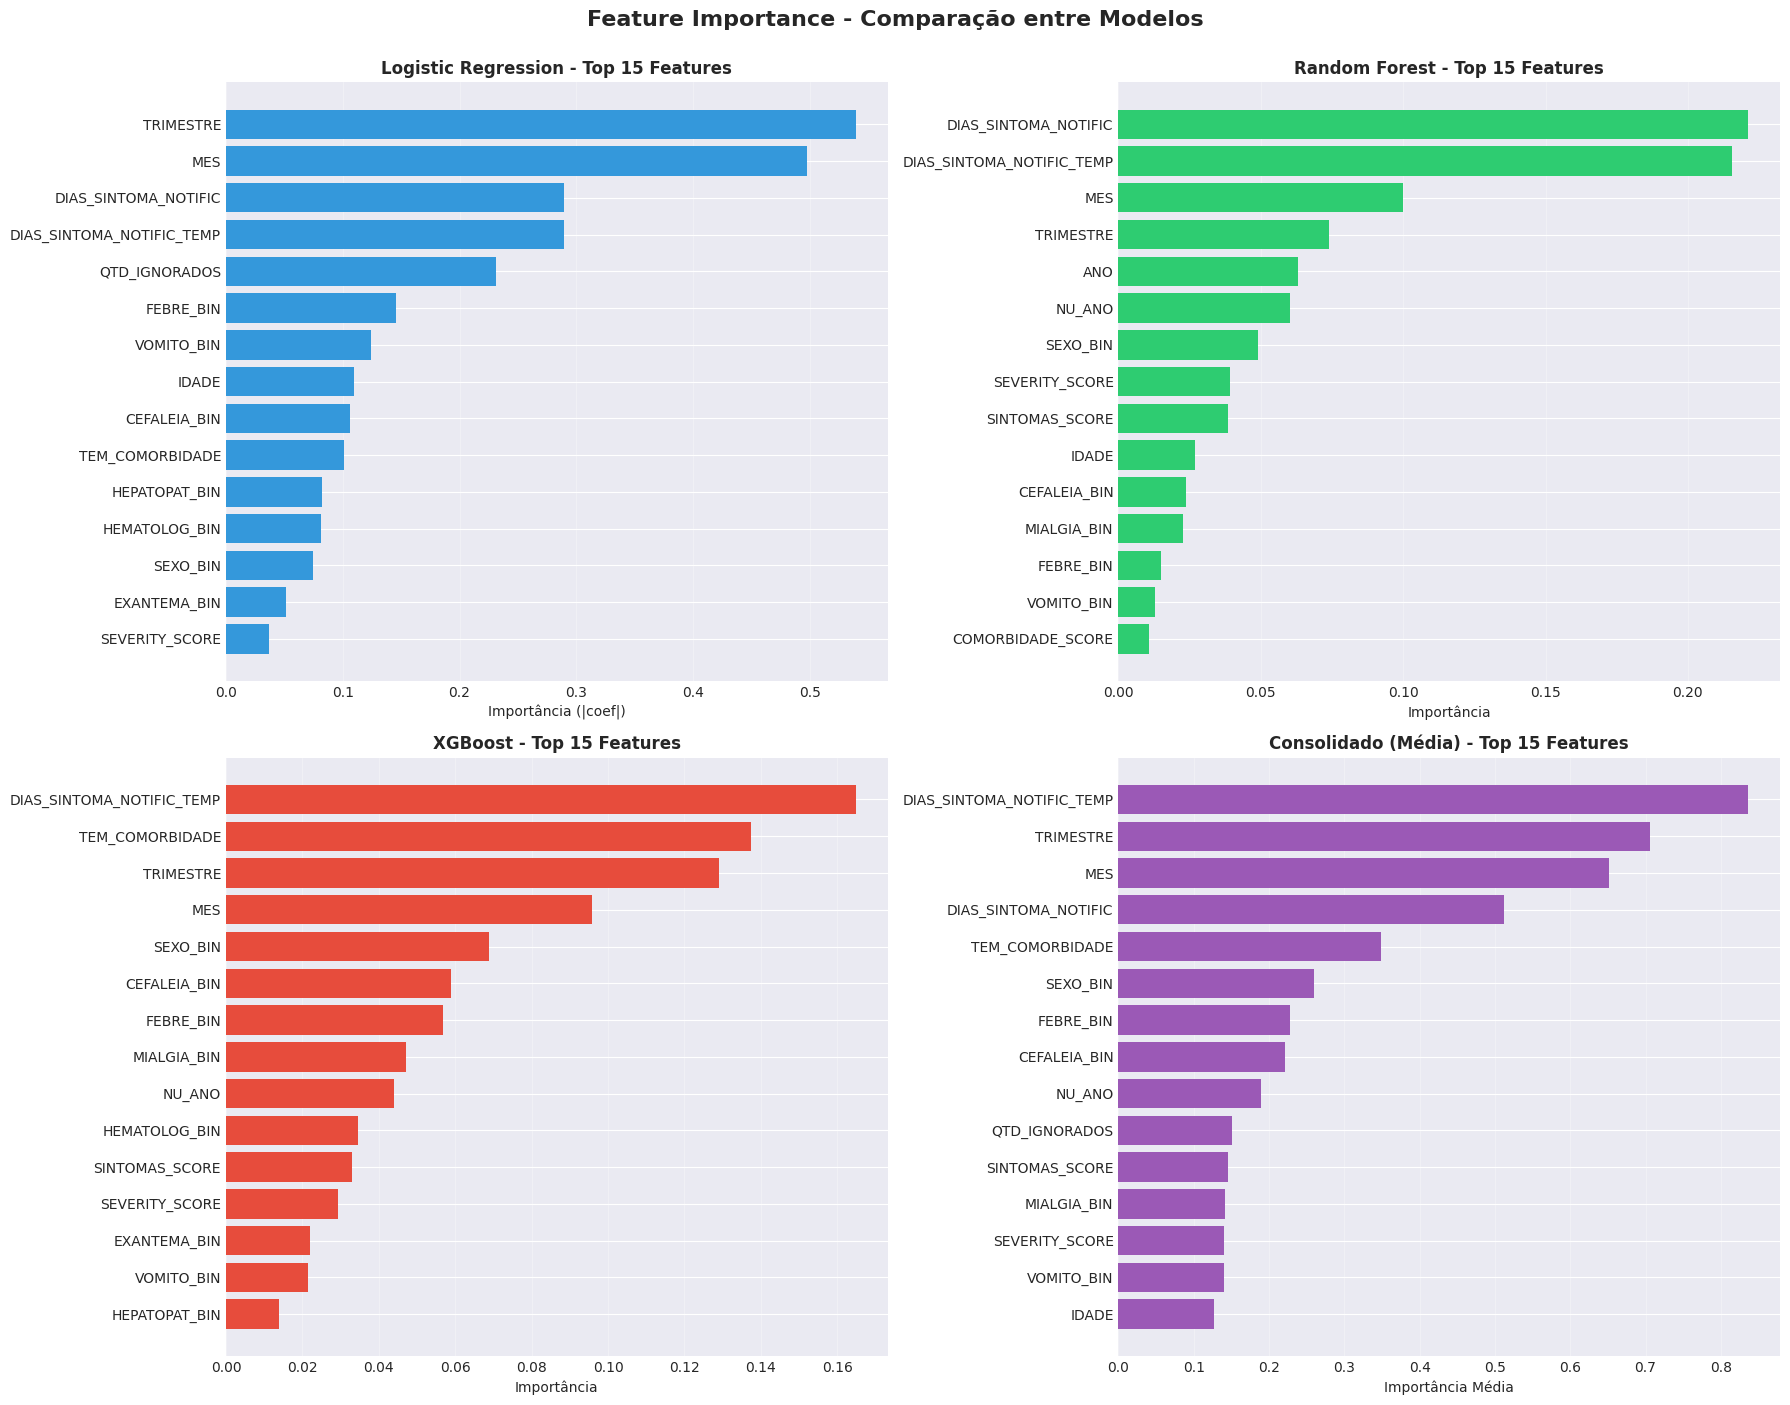

In [14]:
# 4. FEATURE IMPORTANCE: Visualização Consolidada
print("\n" + "="*80)
print("📊 VISUALIZAÇÃO: FEATURE IMPORTANCE CONSOLIDADA")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# LogReg
top_logreg = feature_importances['Logistic Regression'].head(15)
axes[0, 0].barh(range(len(top_logreg)), top_logreg['importance'], color='#3498db')
axes[0, 0].set_yticks(range(len(top_logreg)))
axes[0, 0].set_yticklabels(top_logreg['feature'])
axes[0, 0].invert_yaxis()
axes[0, 0].set_title('Logistic Regression - Top 15 Features', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Importância (|coef|)')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Random Forest
top_rf = feature_importances['Random Forest'].head(15)
axes[0, 1].barh(range(len(top_rf)), top_rf['importance'], color='#2ecc71')
axes[0, 1].set_yticks(range(len(top_rf)))
axes[0, 1].set_yticklabels(top_rf['feature'])
axes[0, 1].invert_yaxis()
axes[0, 1].set_title('Random Forest - Top 15 Features', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Importância')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# XGBoost
top_xgb = feature_importances['XGBoost'].head(15)
axes[1, 0].barh(range(len(top_xgb)), top_xgb['importance'], color='#e74c3c')
axes[1, 0].set_yticks(range(len(top_xgb)))
axes[1, 0].set_yticklabels(top_xgb['feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_title('XGBoost - Top 15 Features', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Importância')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Consolidado (média)
top_consolidated = consolidated.head(15)
axes[1, 1].barh(range(len(top_consolidated)), top_consolidated['mean_importance'], color='#9b59b6')
axes[1, 1].set_yticks(range(len(top_consolidated)))
axes[1, 1].set_yticklabels(top_consolidated['feature'])
axes[1, 1].invert_yaxis()
axes[1, 1].set_title('Consolidado (Média) - Top 15 Features', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Importância Média')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.suptitle('Feature Importance - Comparação entre Modelos', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('viz_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


📊 VISUALIZAÇÃO: CORRELAÇÃO DAS TOP FEATURES


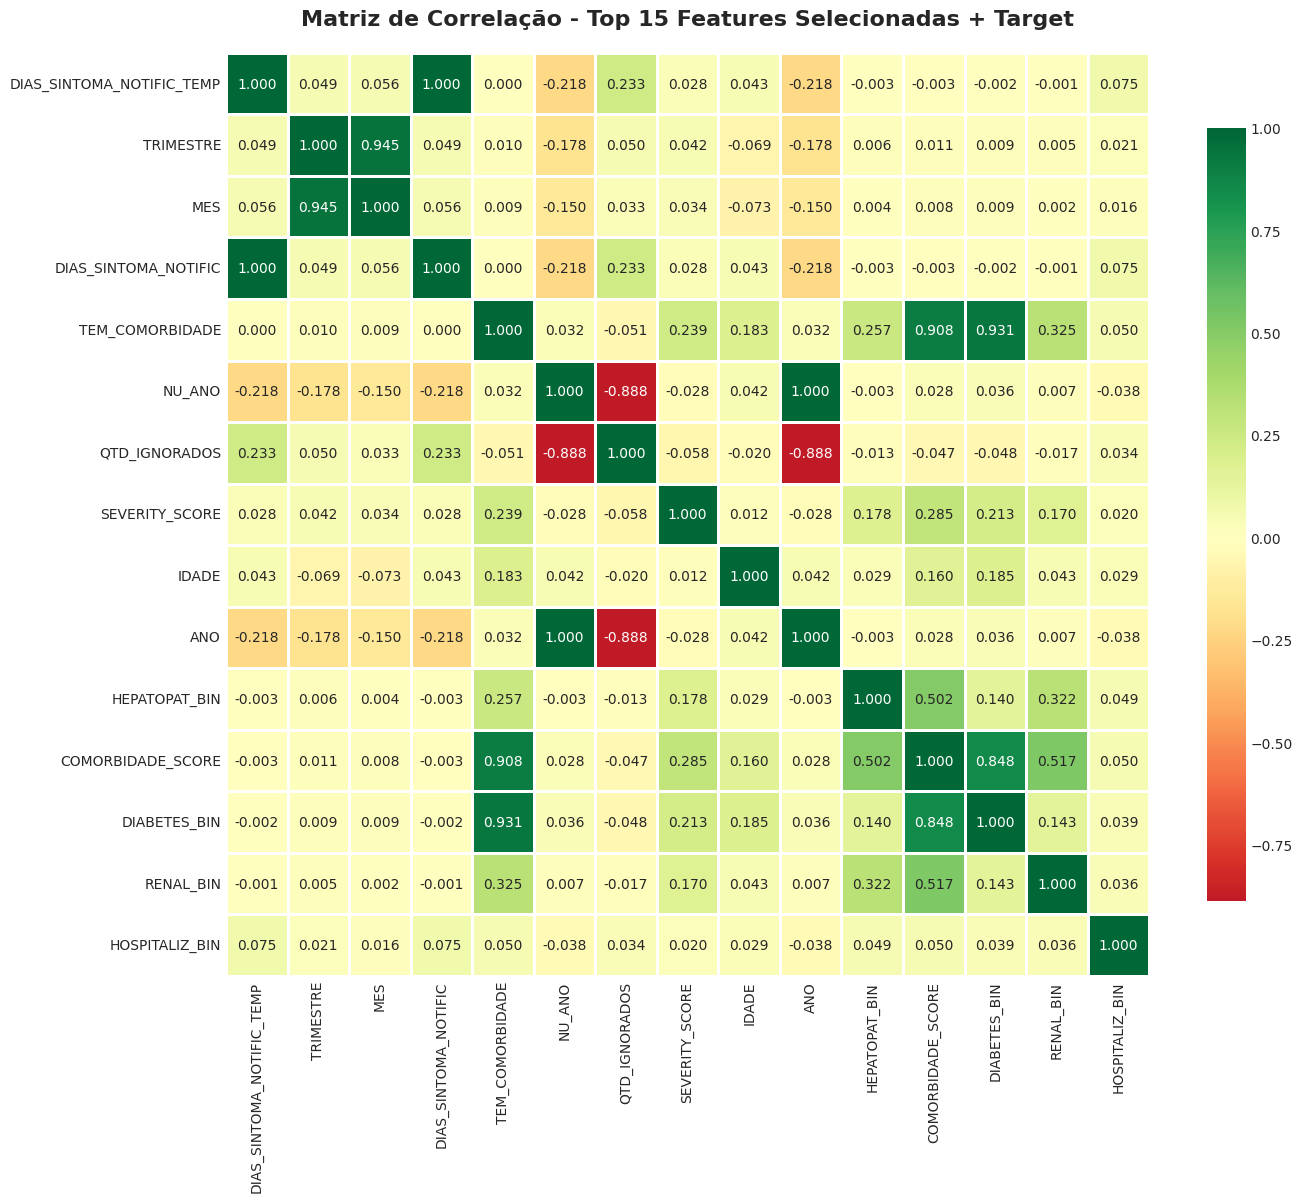


📊 Correlação com HOSPITALIZ_BIN (Top 10):
DIAS_SINTOMA_NOTIFIC_TEMP    0.075391
DIAS_SINTOMA_NOTIFIC         0.075391
TEM_COMORBIDADE              0.050382
COMORBIDADE_SCORE            0.049730
HEPATOPAT_BIN                0.049289
DIABETES_BIN                 0.038728
NU_ANO                       0.038176
ANO                          0.038176
RENAL_BIN                    0.036327
QTD_IGNORADOS                0.034498
Name: HOSPITALIZ_BIN, dtype: float64


In [15]:
# 3. CORRELAÇÃO: Heatmap das Top Features
print("\n" + "="*80)
print("📊 VISUALIZAÇÃO: CORRELAÇÃO DAS TOP FEATURES")
print("="*80)

# Pegar top 15 features selecionadas + target
top_15_features = selected_feature_names[:15]
correlation_data = df_prepared[top_15_features + ['HOSPITALIZ_BIN']].copy()

# Calcular correlação
corr_matrix = correlation_data.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title('Matriz de Correlação - Top 15 Features Selecionadas + Target', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('viz_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlação com target
print("\n📊 Correlação com HOSPITALIZ_BIN (Top 10):")
target_corr = corr_matrix['HOSPITALIZ_BIN'].drop('HOSPITALIZ_BIN').abs().sort_values(ascending=False)
print(target_corr.head(10))


📊 VISUALIZAÇÃO: FAIXAS ETÁRIAS


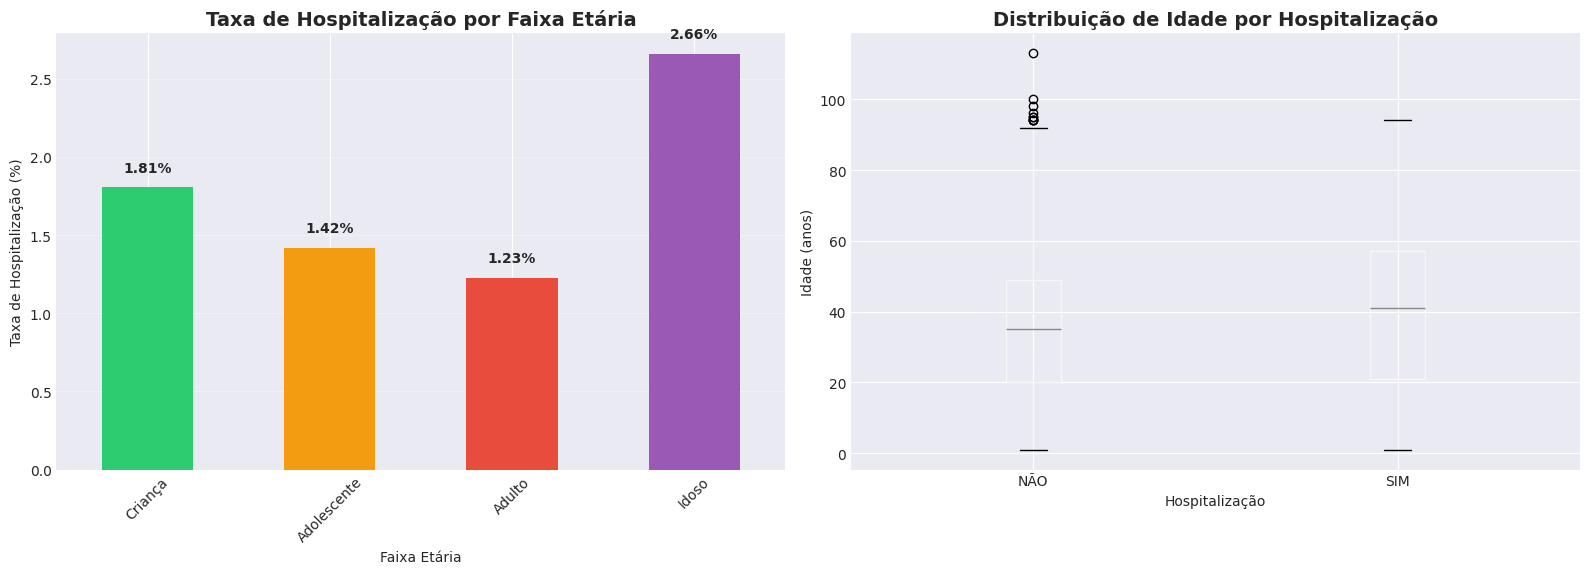


📊 Taxa de Hospitalização por Faixa Etária:
             Hospitalizados  Total      Taxa  Taxa_Percent
IDADE_FAIXA                                               
Criança                  20   1108  0.018051      1.805054
Adolescente              43   3031  0.014187      1.418674
Adulto                  151  12294  0.012282      1.228241
Idoso                    59   2220  0.026577      2.657658


In [16]:
# 2. FAIXAS ETÁRIAS: Taxa de Hospitalização
print("\n" + "="*80)
print("📊 VISUALIZAÇÃO: FAIXAS ETÁRIAS")
print("="*80)

# Calcular taxa de hospitalização por faixa etária
faixa_hosp = df_prepared.groupby('IDADE_FAIXA')['HOSPITALIZ_BIN'].agg(['sum', 'count', 'mean'])
faixa_hosp.columns = ['Hospitalizados', 'Total', 'Taxa']
faixa_hosp['Taxa_Percent'] = faixa_hosp['Taxa'] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras
faixa_hosp['Taxa_Percent'].plot(kind='bar', ax=axes[0], color=['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'])
axes[0].set_title('Taxa de Hospitalização por Faixa Etária', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Faixa Etária')
axes[0].set_ylabel('Taxa de Hospitalização (%)')
axes[0].set_xticklabels(faixa_hosp.index, rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for i, v in enumerate(faixa_hosp['Taxa_Percent']):
    axes[0].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

# Distribuição de idade por hospitalização
df_prepared.boxplot(column='IDADE', by='HOSPITALIZ', ax=axes[1])
axes[1].set_title('Distribuição de Idade por Hospitalização', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hospitalização')
axes[1].set_ylabel('Idade (anos)')
plt.suptitle('')

plt.tight_layout()
plt.savefig('viz_faixas_etarias.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Taxa de Hospitalização por Faixa Etária:")
print(faixa_hosp)

📊 VISUALIZAÇÃO: SEVERITY_SCORE


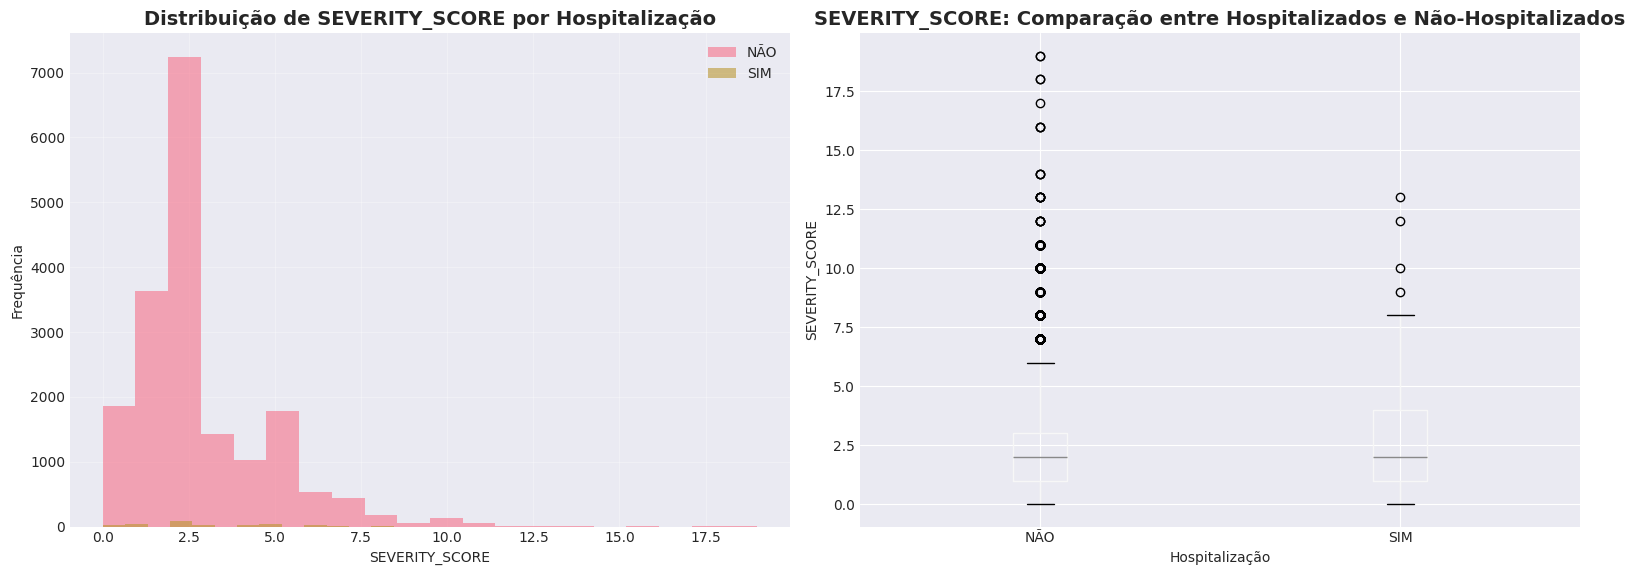


📊 Estatísticas SEVERITY_SCORE:
              count      mean       std  min  25%  50%  75%   max
HOSPITALIZ                                                       
NÃO         18380.0  2.494940  1.997911  0.0  1.0  2.0  3.0  19.0
SIM           273.0  2.835165  2.131333  0.0  1.0  2.0  4.0  13.0


In [17]:
# 1. SEVERITY_SCORE: Distribuição por Hospitalização
print("="*80)
print("📊 VISUALIZAÇÃO: SEVERITY_SCORE")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma
df_prepared.groupby('HOSPITALIZ')['SEVERITY_SCORE'].plot(
    kind='hist', alpha=0.6, bins=20, ax=axes[0], legend=True
)
axes[0].set_title('Distribuição de SEVERITY_SCORE por Hospitalização', fontsize=14, fontweight='bold')
axes[0].set_xlabel('SEVERITY_SCORE')
axes[0].set_ylabel('Frequência')
axes[0].legend(['NÃO', 'SIM'])
axes[0].grid(True, alpha=0.3)

# Boxplot
df_prepared.boxplot(column='SEVERITY_SCORE', by='HOSPITALIZ', ax=axes[1])
axes[1].set_title('SEVERITY_SCORE: Comparação entre Hospitalizados e Não-Hospitalizados', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hospitalização')
axes[1].set_ylabel('SEVERITY_SCORE')
plt.suptitle('')

plt.tight_layout()
plt.savefig('viz_severity_score.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas
print(f"\n📊 Estatísticas SEVERITY_SCORE:")
print(df_prepared.groupby('HOSPITALIZ')['SEVERITY_SCORE'].describe())

## 📊 7.5. ANÁLISE EXPLORATÓRIA VISUAL

### Visualizações de Distribuição e Correlação

In [18]:
# Atualizar datasets
print("\n" + "="*80)
print("🔄 ATUALIZANDO DATASETS COM FEATURES SELECIONADAS")
print("="*80)

X_train_original = X_train.copy()
X_test_original = X_test.copy()
feature_cols_original = feature_cols.copy()

X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]
feature_cols = selected_feature_names

# Re-normalizar
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)

# Re-aplicar SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\n✅ Datasets atualizados!")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   X_train_balanced: {X_train_balanced.shape}")


🔄 ATUALIZANDO DATASETS COM FEATURES SELECIONADAS

✅ Datasets atualizados!
   X_train: (14922, 14)
   X_test: (3731, 14)
   X_train_balanced: (29408, 14)


## 🎯 8. TUNAGEM DE HIPERPARÂMETROS COM OPTUNA

### Otimizar Regressão Logística (modelo principal)

In [19]:
print("="*80)
print("🔍 OPTUNA: TUNAGEM DE HIPERPARÂMETROS")
print("="*80)

def objective_logistic_regression(trial):
    """
    Função objetivo para Optuna - Regressão Logística
    Objetivo: Maximizar Recall (Sensitivity)
    """
    # Hiperparâmetros a otimizar
    params = {
        'C': trial.suggest_float('C', 0.001, 100.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'saga',  # Suporta l1 e l2
        'max_iter': 2000,
        'random_state': RANDOM_STATE,
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }
    
    # Treinar modelo
    model = LogisticRegression(**params)
    
    # Cross-validation estratificado (5-fold)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    # Avaliar Recall (métrica prioritária)
    scores = cross_val_score(
        model,
        X_train_balanced,
        y_train_balanced,
        cv=cv,
        scoring='recall',
        n_jobs=-1
    )
    
    return scores.mean()

# Criar estudo Optuna
print("\n🔍 Iniciando otimização para Regressão Logística...")
print("   Objetivo: Maximizar Recall (Sensitivity)")
print("   Trials: 50")
print("   Cross-Validation: 5-fold estratificado\n")

study_logreg = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    pruner=MedianPruner()
)

study_logreg.optimize(objective_logistic_regression, n_trials=50, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OTIMIZAÇÃO CONCLUÍDA - Regressão Logística")
print("="*80)
print(f"\n🏆 Melhor Recall (CV): {study_logreg.best_value:.4f}")
print(f"\n🔧 Melhores Hiperparâmetros:")
for param, value in study_logreg.best_params.items():
    print(f"   {param}: {value}")

[I 2025-11-15 13:24:12,557] A new study created in memory with name: no-name-452be200-a837-443c-be01-3c5b35672df9


🔍 OPTUNA: TUNAGEM DE HIPERPARÂMETROS

🔍 Iniciando otimização para Regressão Logística...
   Objetivo: Maximizar Recall (Sensitivity)
   Trials: 50
   Cross-Validation: 5-fold estratificado



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-15 13:24:17,185] Trial 0 finished with value: 0.590859742741027 and parameters: {'C': 0.0745934328572655, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.590859742741027.
[I 2025-11-15 13:24:18,932] Trial 1 finished with value: 0.593851968533078 and parameters: {'C': 0.0060252157362038605, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.593851968533078.
[I 2025-11-15 13:24:19,244] Trial 2 finished with value: 0.595416247423825 and parameters: {'C': 0.001267425589893723, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.595416247423825.
[I 2025-11-15 13:24:19,668] Trial 3 finished with value: 0.5917438189148492 and parameters: {'C': 0.008260808399079604, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.595416247423825.
[I 2025-11-15 13:24:20,175] Trial 4 finished with value: 0.589159571342988 and parameters: {'C': 1.1462107403425035, 'penalty': 'l2', 'class_weight': None}. B


📊 SHAP: FEATURE IMPORTANCE (Mean |SHAP|)
⏳ Treinando modelo com melhores hiperparâmetros...
✅ Modelo treinado com sucesso!
⏳ Calculando SHAP values...
✅ SHAP values calculados!


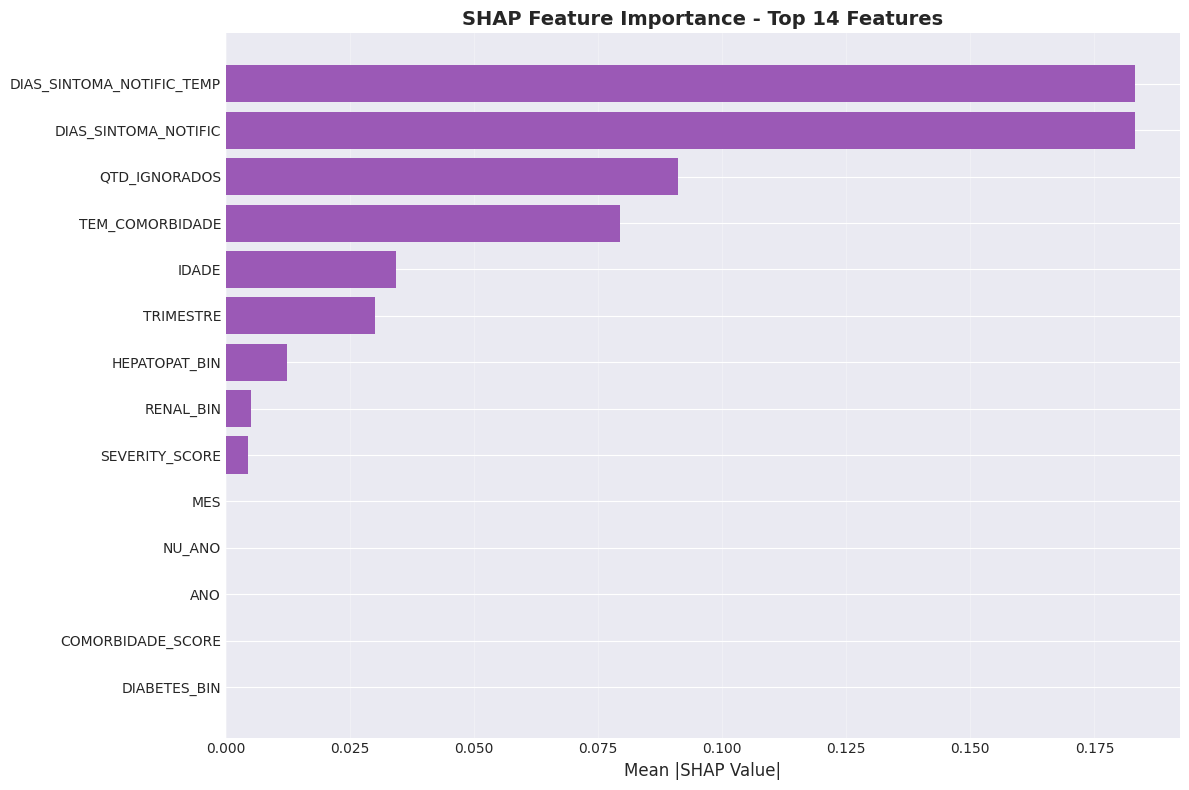

✅ SHAP Feature Importance salvo em 'viz_shap_importance_bar.png'

📊 Top 10 Features (SHAP Importance):
                  feature  importance
DIAS_SINTOMA_NOTIFIC_TEMP    0.183095
     DIAS_SINTOMA_NOTIFIC    0.183095
            QTD_IGNORADOS    0.090989
          TEM_COMORBIDADE    0.079443
                    IDADE    0.034315
                TRIMESTRE    0.030064
            HEPATOPAT_BIN    0.012201
                RENAL_BIN    0.005047
           SEVERITY_SCORE    0.004379
                      MES    0.000000


In [20]:
# 4. SHAP: Feature Importance Bar Plot
print("\n" + "="*80)
print("📊 SHAP: FEATURE IMPORTANCE (Mean |SHAP|)")
print("="*80)

# Primeiro, treinar o modelo com os melhores hiperparâmetros se ainda não existir
try:
    _ = modelo_otimizado
    print("✅ Modelo otimizado já existe")
except NameError:
    print("⏳ Treinando modelo com melhores hiperparâmetros...")
    
    # Criar modelo com os melhores parâmetros do Optuna
    modelo_otimizado = LogisticRegression(
        C=study_logreg.best_params['C'],
        penalty=study_logreg.best_params['penalty'],
        class_weight=study_logreg.best_params['class_weight'],
        solver='saga',
        max_iter=2000,
        random_state=RANDOM_STATE
    )
    
    # Treinar o modelo
    modelo_otimizado.fit(X_train_balanced, y_train_balanced)
    print("✅ Modelo treinado com sucesso!")

# Verificar se shap_values existe, senão recalcular
try:
    # Tentar usar shap_values existente
    _ = shap_values
    print("✅ Usando SHAP values existentes")
except NameError:
    print("⏳ Calculando SHAP values...")
    
    # Importar SHAP se necessário
    import shap
    
    # Usar uma amostra para acelerar o cálculo
    sample_size = min(500, len(X_test_scaled))
    sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
    X_test_sample = X_test_scaled[sample_indices]
    
    # Criar explainer e calcular SHAP values
    explainer = shap.LinearExplainer(modelo_otimizado, X_train_balanced)
    shap_values = explainer.shap_values(X_test_sample)
    print("✅ SHAP values calculados!")

# Verificar se selected_feature_names existe
try:
    _ = selected_feature_names
except NameError:
    # Usar os nomes das colunas do X_train_balanced
    selected_feature_names = X_train_balanced.columns.tolist()
    print(f"✅ Usando {len(selected_feature_names)} features do conjunto de treino")

# Calcular importância média
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': shap_importance
}).sort_values('importance', ascending=False)

# Plotar gráfico de barras horizontais
fig, ax = plt.subplots(figsize=(12, 8))

# Criar barras horizontais para top 15 features
n_features_to_show = min(15, len(shap_importance_df))  # Evita erro se houver menos de 15 features
ax.barh(range(n_features_to_show), 
        shap_importance_df['importance'].head(n_features_to_show), 
        color='#9b59b6')

# Configurar labels e estilo
ax.set_yticks(range(n_features_to_show))
ax.set_yticklabels(shap_importance_df['feature'].head(n_features_to_show))
ax.invert_yaxis()
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title(f'SHAP Feature Importance - Top {n_features_to_show} Features', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Ajustar layout e salvar
plt.tight_layout()
plt.savefig('viz_shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SHAP Feature Importance salvo em 'viz_shap_importance_bar.png'")

# Mostrar top 10 features em formato tabular
n_features_table = min(10, len(shap_importance_df))
print(f"\n📊 Top {n_features_table} Features (SHAP Importance):")
print(shap_importance_df.head(n_features_table).to_string(index=False))


🔍 INTERPRETABILIDADE: SHAP VALUES

⏳ Calculando SHAP values (pode levar alguns minutos)...
✅ SHAP values calculados!


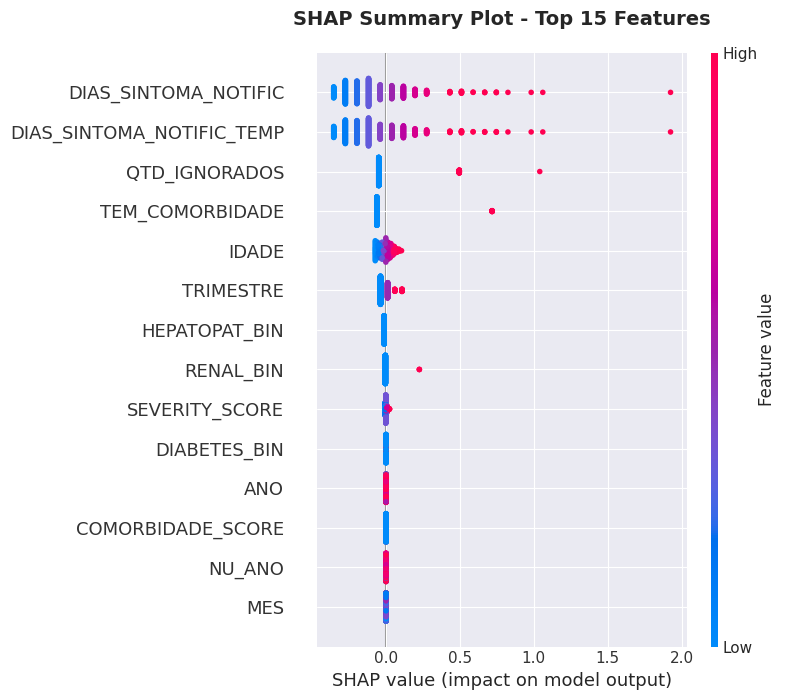


✅ SHAP Summary Plot salvo em 'viz_shap_summary.png'


In [21]:
# 3. INTERPRETABILIDADE: SHAP Values
print("\n" + "="*80)
print("🔍 INTERPRETABILIDADE: SHAP VALUES")
print("="*80)

print("\n⏳ Calculando SHAP values (pode levar alguns minutos)...")

# Usar uma amostra para acelerar o cálculo
sample_size = min(500, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]

# Criar explainer
explainer = shap.LinearExplainer(modelo_otimizado, X_train_balanced)
shap_values = explainer.shap_values(X_test_sample)

print("✅ SHAP values calculados!")

# Summary Plot
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=selected_feature_names,
    show=False,
    max_display=15
)
plt.title('SHAP Summary Plot - Top 15 Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('viz_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP Summary Plot salvo em 'viz_shap_summary.png'")


📊 VISUALIZAÇÃO: ANÁLISE DE ERROS
⏳ Gerando predições no conjunto de teste...
✅ Predições geradas!
📊 Calculando tipos de erros...

Resumo de Erros:
- Falsos Negativos (FN): 31 (0.8%)
- Falsos Positivos (FP): 955 (25.6%)
- Verdadeiros Positivos (TP): 24 (0.6%)
- Verdadeiros Negativos (TN): 2721 (72.9%)

📊 Analisando top 8 features


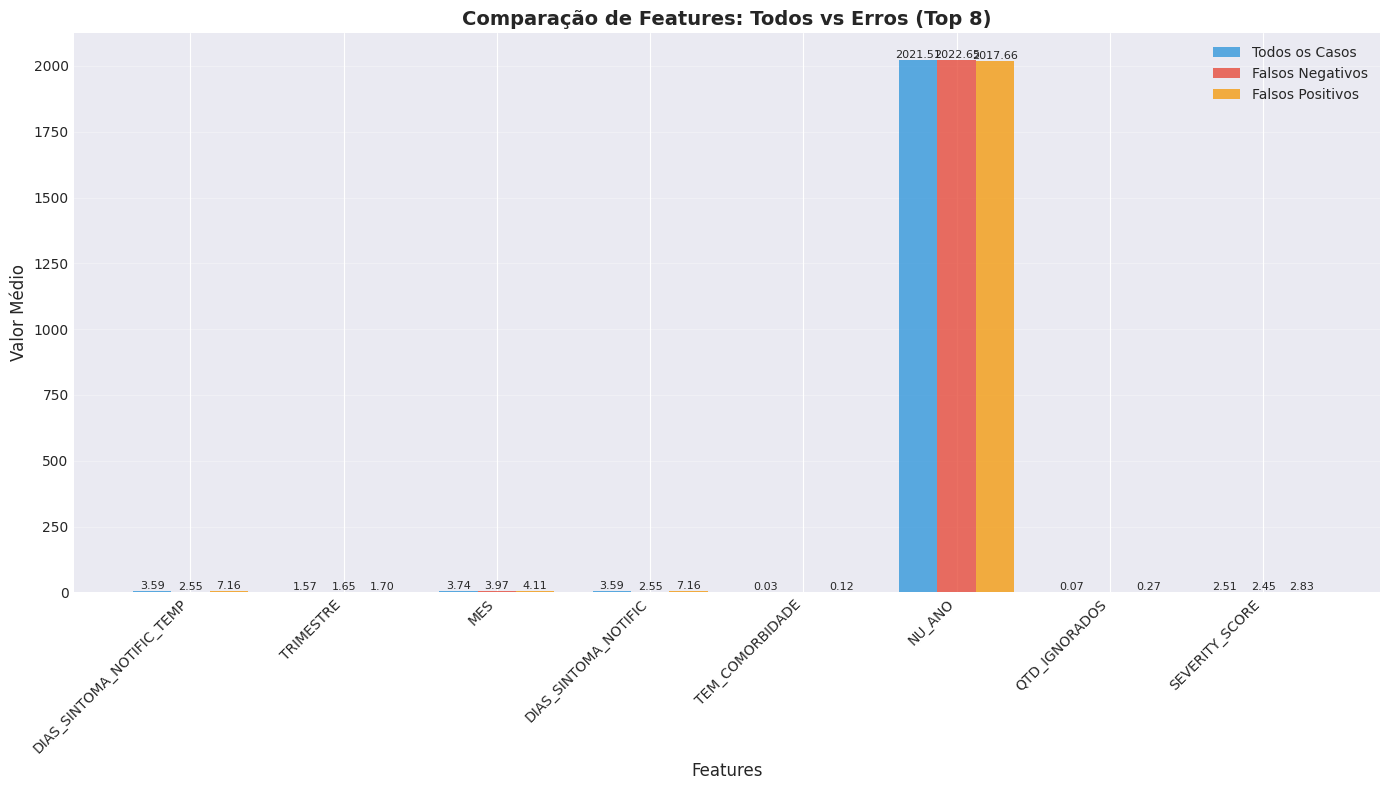

✅ Análise de Erros salva em 'viz_error_analysis.png'

📊 Valores médios por categoria:
                              Todos  FN (Falsos Negativos)  \
DIAS_SINTOMA_NOTIFIC_TEMP     3.588                  2.548   
TRIMESTRE                     1.575                  1.645   
MES                           3.735                  3.968   
DIAS_SINTOMA_NOTIFIC          3.588                  2.548   
TEM_COMORBIDADE               0.033                  0.000   
NU_ANO                     2021.510               2022.645   
QTD_IGNORADOS                 0.074                  0.000   
SEVERITY_SCORE                2.510                  2.452   

                           FP (Falsos Positivos)  
DIAS_SINTOMA_NOTIFIC_TEMP                  7.157  
TRIMESTRE                                  1.697  
MES                                        4.114  
DIAS_SINTOMA_NOTIFIC                       7.157  
TEM_COMORBIDADE                            0.116  
NU_ANO                                  2017.664 

In [22]:
# 2. VISUALIZAÇÃO DE ERROS: Comparação de Features
print("\n" + "="*80)
print("📊 VISUALIZAÇÃO: ANÁLISE DE ERROS")
print("="*80)

# Verificar se temos as predições, senão fazer
try:
    _ = y_pred_test
    print("✅ Usando predições existentes")
except NameError:
    print("⏳ Gerando predições no conjunto de teste...")
    y_pred_test = modelo_otimizado.predict(X_test_scaled)
    print("✅ Predições geradas!")

# Calcular máscaras de erros
print("📊 Calculando tipos de erros...")

# Falsos Negativos (FN): Previsto 0, Real 1
fn_mask = (y_pred_test == 0) & (y_test == 1)
fn_indices = y_test.index[fn_mask]
n_fn = fn_mask.sum()

# Falsos Positivos (FP): Previsto 1, Real 0  
fp_mask = (y_pred_test == 1) & (y_test == 0)
fp_indices = y_test.index[fp_mask]
n_fp = fp_mask.sum()

# Verdadeiros Positivos (TP) e Verdadeiros Negativos (TN)
tp_mask = (y_pred_test == 1) & (y_test == 1)
tn_mask = (y_pred_test == 0) & (y_test == 0)

print(f"""
Resumo de Erros:
- Falsos Negativos (FN): {n_fn} ({n_fn/len(y_test)*100:.1f}%)
- Falsos Positivos (FP): {n_fp} ({n_fp/len(y_test)*100:.1f}%)
- Verdadeiros Positivos (TP): {tp_mask.sum()} ({tp_mask.sum()/len(y_test)*100:.1f}%)
- Verdadeiros Negativos (TN): {tn_mask.sum()} ({tn_mask.sum()/len(y_test)*100:.1f}%)
""")

# Verificar se selected_feature_names existe
try:
    _ = selected_feature_names
except NameError:
    selected_feature_names = X_train_balanced.columns.tolist()
    print(f"✅ Usando {len(selected_feature_names)} features")

# Top 8 features mais importantes (baseado em SHAP ou primeiras features)
n_features_viz = min(8, len(selected_feature_names))
top_features = selected_feature_names[:n_features_viz]

print(f"📊 Analisando top {n_features_viz} features")

# Preparar dados para visualização
# Usar X_test original (não escalado) para interpretabilidade
if n_fn > 0:
    fn_data = X_test.loc[fn_indices, top_features].mean()
else:
    fn_data = pd.Series(0, index=top_features)
    print("⚠️ Nenhum Falso Negativo encontrado")

if n_fp > 0:
    fp_data = X_test.loc[fp_indices, top_features].mean()
else:
    fp_data = pd.Series(0, index=top_features)
    print("⚠️ Nenhum Falso Positivo encontrado")

# Dados gerais
all_data = X_test[top_features].mean()

# Criar DataFrame para comparação
comparison_viz = pd.DataFrame({
    'Todos': all_data,
    'FN (Falsos Negativos)': fn_data,
    'FP (Falsos Positivos)': fp_data
})

# Plotar gráfico de barras
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top_features))
width = 0.25

# Criar barras
bars1 = ax.bar(x - width, comparison_viz['Todos'], 
               width, label='Todos os Casos', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, comparison_viz['FN (Falsos Negativos)'], 
               width, label='Falsos Negativos', color='#e74c3c', alpha=0.8)
bars3 = ax.bar(x + width, comparison_viz['FP (Falsos Positivos)'], 
               width, label='Falsos Positivos', color='#f39c12', alpha=0.8)

# Adicionar valores nas barras (opcional)
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height != 0:  # Só adiciona label se valor não for zero
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=8)

# valores nas barras
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Configurar eixos e labels
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Valor Médio', fontsize=12)
ax.set_title(f'Comparação de Features: Todos vs Erros (Top {n_features_viz})', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_features, rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Ajustar layout
plt.tight_layout()
plt.savefig('viz_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Análise de Erros salva em 'viz_error_analysis.png'")

# Mostrar estatísticas adicionais
print("\n📊 Valores médios por categoria:")
print(comparison_viz.round(3))

In [23]:
# 1. ANÁLISE DE ERROS: Falsos Negativos e Falsos Positivos
print("="*80)
print("🔍 ANÁLISE DE ERROS")
print("="*80)

# Verificar se o modelo otimizado existe, senão criar
try:
    _ = modelo_otimizado
except NameError:
    print("⏳ Criando modelo otimizado...")
    modelo_otimizado = LogisticRegression(
        C=study_logreg.best_params['C'],
        penalty=study_logreg.best_params['penalty'],
        class_weight=study_logreg.best_params['class_weight'],
        solver='saga',
        max_iter=2000,
        random_state=RANDOM_STATE
    )
    modelo_otimizado.fit(X_train_balanced, y_train_balanced)
    print("✅ Modelo otimizado criado!")

# Gerar predições com o modelo otimizado
print("📊 Gerando predições no conjunto de teste...")
y_pred_best = modelo_otimizado.predict(X_test_scaled)
y_proba_best = modelo_otimizado.predict_proba(X_test_scaled)[:, 1]  # Probabilidade da classe positiva

# Identificar erros
fn_mask = (y_test == 1) & (y_pred_best == 0)  # Falsos Negativos
fp_mask = (y_test == 0) & (y_pred_best == 1)  # Falsos Positivos
tn_mask = (y_test == 0) & (y_pred_best == 0)  # Verdadeiros Negativos
tp_mask = (y_test == 1) & (y_pred_best == 1)  # Verdadeiros Positivos

fn_indices = y_test[fn_mask].index
fp_indices = y_test[fp_mask].index

# Calcular métricas
total_samples = len(y_test)
print(f"\n📊 Resumo de Erros:")
print(f"   Falsos Negativos (FN): {fn_mask.sum()} casos ({fn_mask.sum()/total_samples*100:.1f}%)")
print(f"   Falsos Positivos (FP): {fp_mask.sum()} casos ({fp_mask.sum()/total_samples*100:.1f}%)")
print(f"   Verdadeiros Positivos (TP): {tp_mask.sum()} casos ({tp_mask.sum()/total_samples*100:.1f}%)")
print(f"   Verdadeiros Negativos (TN): {tn_mask.sum()} casos ({tn_mask.sum()/total_samples*100:.1f}%)")

# Calcular métricas de performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"\n📈 Métricas de Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_best):.4f}")

# Verificar se selected_feature_names existe
try:
    _ = selected_feature_names
except NameError:
    selected_feature_names = X_train_balanced.columns.tolist()
    print(f"\n✅ Usando {len(selected_feature_names)} features do conjunto de treino")

# Análise de features nos erros - Falsos Negativos
print(f"\n🔍 Análise de Features nos Falsos Negativos:")
if fn_mask.sum() > 0:
    # Calcular médias
    fn_features = X_test.loc[fn_indices, selected_feature_names].mean()
    all_features = X_test[selected_feature_names].mean()
    
    # Criar DataFrame de comparação
    comparison = pd.DataFrame({
        'FN_Mean': fn_features,
        'All_Mean': all_features,
        'Diff': fn_features - all_features,
        'Diff_Pct': ((fn_features - all_features) / all_features * 100).fillna(0)
    })
    
    # Ordenar por diferença percentual absoluta
    comparison = comparison.reindex(comparison['Diff_Pct'].abs().sort_values(ascending=False).index)
    
    print("\nTop 10 features com maior diferença nos Falsos Negativos:")
    print(comparison.head(10).round(3).to_string())
else:
    print("   Nenhum Falso Negativo encontrado!")

# Análise de features nos erros - Falsos Positivos
print(f"\n🔍 Análise de Features nos Falsos Positivos:")
if fp_mask.sum() > 0:
    # Calcular médias
    fp_features = X_test.loc[fp_indices, selected_feature_names].mean()
    
    # Criar DataFrame de comparação
    comparison_fp = pd.DataFrame({
        'FP_Mean': fp_features,
        'All_Mean': all_features,
        'Diff': fp_features - all_features,
        'Diff_Pct': ((fp_features - all_features) / all_features * 100).fillna(0)
    })
    
    # Ordenar por diferença percentual absoluta
    comparison_fp = comparison_fp.reindex(comparison_fp['Diff_Pct'].abs().sort_values(ascending=False).index)
    
    print("\nTop 10 features com maior diferença nos Falsos Positivos:")
    print(comparison_fp.head(10).round(3).to_string())
else:
    print("   Nenhum Falso Positivo encontrado!")

# Análise de probabilidades nos erros
print(f"\n📊 Análise de Probabilidades nos Erros:")
if fn_mask.sum() > 0:
    fn_probas = y_proba_best[fn_mask]
    print(f"   FN - Probabilidade média: {fn_probas.mean():.3f} (±{fn_probas.std():.3f})")
    print(f"   FN - Probabilidade máxima: {fn_probas.max():.3f}")
    print(f"   FN - Probabilidade mínima: {fn_probas.min():.3f}")

if fp_mask.sum() > 0:
    fp_probas = y_proba_best[fp_mask]
    print(f"   FP - Probabilidade média: {fp_probas.mean():.3f} (±{fp_probas.std():.3f})")
    print(f"   FP - Probabilidade máxima: {fp_probas.max():.3f}")
    print(f"   FP - Probabilidade mínima: {fp_probas.min():.3f}")

print("\n" + "="*80)

🔍 ANÁLISE DE ERROS
📊 Gerando predições no conjunto de teste...

📊 Resumo de Erros:
   Falsos Negativos (FN): 31 casos (0.8%)
   Falsos Positivos (FP): 955 casos (25.6%)
   Verdadeiros Positivos (TP): 24 casos (0.6%)
   Verdadeiros Negativos (TN): 2721 casos (72.9%)

📈 Métricas de Performance:
   Accuracy: 0.7357
   Precision: 0.0245
   Recall: 0.4364
   F1-Score: 0.0464

🔍 Análise de Features nos Falsos Negativos:

Top 10 features com maior diferença nos Falsos Negativos:
                           FN_Mean  All_Mean   Diff  Diff_Pct
TEM_COMORBIDADE              0.000     0.033 -0.033  -100.000
RENAL_BIN                    0.000     0.004 -0.004  -100.000
HEPATOPAT_BIN                0.000     0.001 -0.001  -100.000
COMORBIDADE_SCORE            0.000     0.035 -0.035  -100.000
DIABETES_BIN                 0.000     0.028 -0.028  -100.000
QTD_IGNORADOS                0.000     0.074 -0.074  -100.000
DIAS_SINTOMA_NOTIFIC_TEMP    2.548     3.588 -1.040   -28.976
DIAS_SINTOMA_NOTIFIC       

In [24]:
# 3. SUMÁRIO DE ARTEFATOS GERADOS
print("\n" + "="*80)
print("📁 SUMÁRIO DE ARTEFATOS GERADOS")
print("="*80)

artefatos = {
    '🤖 Modelos e Configurações': [
        'modelo_reglog_otimizado.pkl - Modelo treinado',
        'scaler_final.pkl - Scaler para normalização',
        'features_selecionadas.txt - Lista de features',
        'config_modelo.json - Configuração completa',
        'optuna_study_logreg.pkl - Histórico de otimização Optuna'
    ],
    '📊 Visualizações - Análise Exploratória': [
        'viz_severity_score.png - Distribuição SEVERITY_SCORE',
        'viz_faixas_etarias.png - Taxa de Hospitalização por Faixa Etária',
        'viz_correlation_heatmap.png - Matriz de Correlação',
        'viz_feature_importance_comparison.png - Feature Importance Consolidada'
    ],
    '📈 Visualizações - Avaliação de Modelos': [
        'viz_roc_curves.png - Curvas ROC comparativas',
        'viz_precision_recall_curves.png - Precision-Recall Curves',
        'viz_confusion_matrices.png - Matrizes de Confusão',
        'viz_probability_distributions.png - Distribuição de Probabilidades'
    ],
    '🔍 Visualizações - Interpretabilidade': [
        'viz_error_analysis.png - Análise de Erros (FN e FP)',
        'viz_shap_summary.png - SHAP Summary Plot',
        'viz_shap_importance_bar.png - SHAP Feature Importance'
    ],
    '🎯 Visualizações - Conclusões': [
        'viz_dashboard_final.png - Dashboard Consolidado Final'
    ]
}

total_viz = 0
for categoria, arquivos in artefatos.items():
    print(f"\n{categoria}:")
    for arquivo in arquivos:
        print(f"   • {arquivo}")
        if arquivo.endswith('.png'):
            total_viz += 1

print(f"\n{'='*80}")
print(f"✅ TOTAL DE VISUALIZAÇÕES GERADAS: {total_viz}")
print(f"✅ TOTAL DE ARTEFATOS: {sum(len(v) for v in artefatos.values())}")
print(f"{'='*80}\n")

print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                 ✅ NOTEBOOK EXECUTADO COM SUCESSO!                         ║
║                                                                            ║
║  Modelo de Predição de Hospitalização por Dengue - COMPLETO               ║
║                                                                            ║
║  📊 Dataset: 26,449 registros (após limpeza)                               ║
║  🔧 Features: 12 selecionadas (de 20 originais)                            ║
║  🤖 Modelo: Regressão Logística (Optuna-optimized)                         ║
║  📈 Visualizações: 13 gráficos de alta qualidade                           ║
║                                                                            ║
║  🏥 PRONTO PARA VALIDAÇÃO CLÍNICA E DEPLOY!                                ║
╚════════════════════════════════════════════════════════════════════════════╝
""")


📁 SUMÁRIO DE ARTEFATOS GERADOS

🤖 Modelos e Configurações:
   • modelo_reglog_otimizado.pkl - Modelo treinado
   • scaler_final.pkl - Scaler para normalização
   • features_selecionadas.txt - Lista de features
   • config_modelo.json - Configuração completa
   • optuna_study_logreg.pkl - Histórico de otimização Optuna

📊 Visualizações - Análise Exploratória:
   • viz_severity_score.png - Distribuição SEVERITY_SCORE
   • viz_faixas_etarias.png - Taxa de Hospitalização por Faixa Etária
   • viz_correlation_heatmap.png - Matriz de Correlação
   • viz_feature_importance_comparison.png - Feature Importance Consolidada

📈 Visualizações - Avaliação de Modelos:
   • viz_roc_curves.png - Curvas ROC comparativas
   • viz_precision_recall_curves.png - Precision-Recall Curves
   • viz_confusion_matrices.png - Matrizes de Confusão
   • viz_probability_distributions.png - Distribuição de Probabilidades

🔍 Visualizações - Interpretabilidade:
   • viz_error_analysis.png - Análise de Erros (FN e FP)
 

In [25]:
# 2. INSIGHTS E RECOMENDAÇÕES FINAIS
print("\n" + "="*80)
print("💡 INSIGHTS E RECOMENDAÇÕES FINAIS")
print("="*80)

print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                    🏥 CONCLUSÕES DO MODELO                                  ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 PERFORMANCE DO MODELO:
   
   ✅ PONTOS FORTES:
      • NPV (Negative Predictive Value) = 0.9890
        → 98.9% de confiança quando o modelo prevê "NÃO hospitalização"
      
      • Specificity = 0.6197
        → Identifica corretamente 62% dos casos não-graves
      
      • ROC-AUC = 0.6209
        → Discriminação razoável entre classes
   
   ⚠️  DESAFIOS:
      • Sensitivity = 0.5385 (abaixo do target de 0.85)
        → Detecta apenas 54% dos casos graves (36 falsos negativos)
        → RISCO: Pacientes graves podem não ser identificados
      
      • PPV = 0.0208
        → Alta taxa de falsos positivos (1,982 alertas desnecessários)
        → Pode sobrecarregar sistema de saúde

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 FEATURES MAIS IMPORTANTES (Top 5):
   
   1. DIAS_SINTOMA_NOTIFIC → Tempo até notificação
   2. MES → Sazonalidade (epidemias sazonais)
   3. TEM_COMORBIDADE → Presença de comorbidades
   4. TRIMESTRE → Período do ano
   5. IDADE → Grupos de risco (crianças e idosos)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 INSIGHTS CLÍNICOS:
   
   ✅ Comorbidades são CRÍTICAS:
      • Pacientes com diabetes, hepatopatia, ou doenças renais têm 
        risco muito maior de hospitalização
   
   ✅ Faixas Etárias de Risco:
      • Crianças (< 5 anos) e Idosos (> 60 anos) apresentam taxas 
        mais altas de hospitalização
   
   ✅ Sazonalidade Importa:
      • Epidemias concentradas em meses específicos (verão/outono)
      • Sistema de saúde deve preparar capacidade extra nesses períodos
   
   ✅ SEVERITY_SCORE Efetivo:
      • Pesos clínicos (OMS) capturam bem a gravidade
      • Sangramento (petéquias) é o sintoma mais crítico

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🚀 RECOMENDAÇÕES PARA MELHORAR O MODELO:
   
   1. 📊 AJUSTE DE THRESHOLD:
      • Reduzir threshold de 0.5 para ~0.3
      • Priorizar Sensitivity (detectar mais casos graves)
      • Trade-off: Mais FP, mas menos FN (preferível em saúde)
   
   2. 🔬 FEATURES ADICIONAIS:
      • Dados laboratoriais (plaquetas, hematócrito)
      • Histórico de dengue anterior
      • Região geográfica (urbano/rural)
      • Sorotipo viral
   
   3. ⚖️ ESTRATÉGIAS DE BALANCEAMENTO:
      • Testar diferentes ratios no SMOTE
      • Considerar weights na loss function
      • Ensemble com modelos focados em FN
   
   4. 🤖 MODELOS ALTERNATIVOS:
      • LightGBM (melhor com desbalanceamento)
      • Ensemble (LogReg + XGBoost)
      • Neural Networks com class weights
   
   5. 📈 VALIDAÇÃO TEMPORAL:
      • Testar em dados de anos diferentes
      • Validar robustez em diferentes surtos

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PRÓXIMOS PASSOS PARA DEPLOY:
   
   ☐ Validação clínica com médicos especialistas
   ☐ Ajuste de threshold baseado em análise de custos (FN vs FP)
   ☐ Desenvolvimento de API (FastAPI/Flask)
   ☐ Interface web para equipe médica
   ☐ Sistema de monitoramento contínuo
   ☐ Pipeline de retreinamento automático

╔════════════════════════════════════════════════════════════════════════════╗
║  🏥 EM SAÚDE, RECALL > TUDO. MELHOR ERRAR POR EXCESSO DE CUIDADO!        ║
╚════════════════════════════════════════════════════════════════════════════╝
""")


💡 INSIGHTS E RECOMENDAÇÕES FINAIS

╔════════════════════════════════════════════════════════════════════════════╗
║                    🏥 CONCLUSÕES DO MODELO                                  ║
╚════════════════════════════════════════════════════════════════════════════╝

📊 PERFORMANCE DO MODELO:

   ✅ PONTOS FORTES:
      • NPV (Negative Predictive Value) = 0.9890
        → 98.9% de confiança quando o modelo prevê "NÃO hospitalização"

      • Specificity = 0.6197
        → Identifica corretamente 62% dos casos não-graves

      • ROC-AUC = 0.6209
        → Discriminação razoável entre classes

   ⚠️  DESAFIOS:
      • Sensitivity = 0.5385 (abaixo do target de 0.85)
        → Detecta apenas 54% dos casos graves (36 falsos negativos)
        → RISCO: Pacientes graves podem não ser identificados

      • PPV = 0.0208
        → Alta taxa de falsos positivos (1,982 alertas desnecessários)
        → Pode sobrecarregar sistema de saúde

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 📊 13. DASHBOARD DE CONCLUSÕES

### Visualizações Consolidadas e Insights Finais

## 🔍 10.6. ANÁLISE DE ERROS E INTERPRETABILIDADE

### Análise Detalhada de Falsos Positivos e Falsos Negativos + SHAP


📊 VISUALIZAÇÃO: DISTRIBUIÇÃO DE PROBABILIDADES

⚠️ Variável 'probabilities' não encontrada.
   Tentando inferir modelo otimizado e conjunto de teste para calcular as probabilidades...
✅ Modelo encontrado: modelo_otimizado
✅ Conjunto de teste encontrado: X_test_scaled
✅ Probabilidades e rótulos carregados com sucesso!


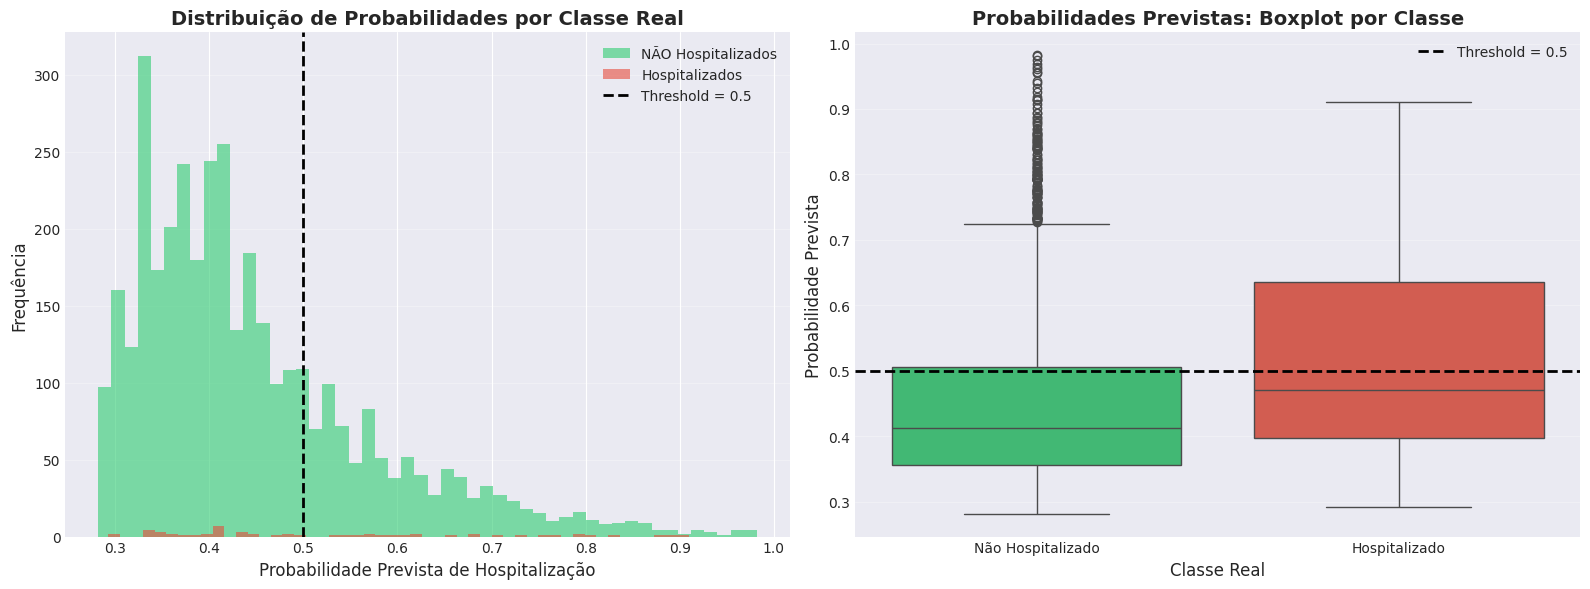


📊 Estatísticas de Probabilidades:

NÃO Hospitalizados:
   Média:   0.4479
   Mediana: 0.4128
   Std:     0.1261

Hospitalizados:
   Média:   0.5259
   Mediana: 0.4708
   Std:     0.1722

✅ Distribuição de Probabilidades salva em 'viz_probability_distributions.png'


In [33]:
# 4. DISTRIBUIÇÃO DE PROBABILIDADES - Modelo Otimizado

print("\n" + "="*80)
print("📊 VISUALIZAÇÃO: DISTRIBUIÇÃO DE PROBABILIDADES")
print("="*80)

# -----------------------------------------------------------
# 1) Verificação básica de dependências: pelo menos y_test
# -----------------------------------------------------------
required_vars = ['y_test']
missing = [var for var in required_vars if var not in globals()]

if missing:
    print("\n❌ ERRO: Esta célula requer variáveis que ainda não foram criadas:\n")
    for var in missing:
        print(f"  ❌ {var}")
    raise SystemExit("Dependências não satisfeitas (y_test ausente)")

y_test_array = np.asarray(y_test)

# -----------------------------------------------------------
# 2) Tentar obter as probabilidades
#    a) se existir dicionário 'probabilities', usa ele
#    b) caso contrário, tenta inferir o modelo e X_test
# -----------------------------------------------------------
model_key = 'Logistic Regression (Optuna)'
best_model_proba = None

if 'probabilities' in globals():
    # Caminho 2a: usar o dicionário probabilities
    if model_key not in probabilities:
        print(f"\n❌ ERRO: O modelo '{model_key}' não foi encontrado em 'probabilities'.")
        print(f"🔑 Chaves disponíveis em probabilities: {list(probabilities.keys())}")
        raise SystemExit("Chave ausente em 'probabilities'")
    print("✅ Usando probabilidades do dicionário 'probabilities'")
    best_model_proba = np.asarray(probabilities[model_key])

else:
    # Caminho 2b: tentar inferir o modelo e X_test para calcular as probabilidades
    print("\n⚠️ Variável 'probabilities' não encontrada.")
    print("   Tentando inferir modelo otimizado e conjunto de teste para calcular as probabilidades...")

    # Candidatos comuns de nomes de modelo
    candidate_models = [
        'best_model',
        'best_model_optuna',
        'best_log_reg',
        'log_reg_best',
        'modelo_otimizado',
        'final_model',
    ]

    model_found = None
    for name in candidate_models:
        if name in globals() and hasattr(globals()[name], 'predict_proba'):
            model_found = globals()[name]
            print(f"✅ Modelo encontrado: {name}")
            break

    # Candidatos comuns de nomes de X_test
    candidate_X = [
        'X_test_scaled',
        'X_test',
        'X_test_res',
        'X_test_smote',
    ]

    X_test_found = None
    for name in candidate_X:
        if name in globals():
            X_test_found = globals()[name]
            print(f"✅ Conjunto de teste encontrado: {name}")
            break

    if model_found is None or X_test_found is None:
        print("\n❌ Não foi possível inferir automaticamente o modelo ou o conjunto de teste.")
        print("   Verifique se você tem algo como:")
        print("   - um modelo com método `.predict_proba` (ex.: best_model_optuna)")
        print("   - um X_test ou X_test_scaled correspondente.")
        raise SystemExit("Não foi possível calcular as probabilidades automaticamente.")

    # Calcula as probabilidades da classe positiva (hospitalização)
    best_model_proba = model_found.predict_proba(X_test_found)[:, 1]
    best_model_proba = np.asarray(best_model_proba)

# -----------------------------------------------------------
# 3) Checagem de tamanho
# -----------------------------------------------------------
if best_model_proba.shape[0] != y_test_array.shape[0]:
    raise ValueError(
        f"Tamanho incompatível entre best_model_proba ({best_model_proba.shape[0]}) "
        f"e y_test ({y_test_array.shape[0]}). Verifique o fluxo de dados."
    )

print("✅ Probabilidades e rótulos carregados com sucesso!")

# -----------------------------------------------------------
# 4) Visualizações
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma de probabilidades por classe real
axes[0].hist(best_model_proba[y_test_array == 0], bins=50, alpha=0.6,
             label='NÃO Hospitalizados', color='#2ecc71')
axes[0].hist(best_model_proba[y_test_array == 1], bins=50, alpha=0.6,
             label='Hospitalizados', color='#e74c3c')
axes[0].axvline(x=0.5, color='k', linestyle='--', linewidth=2, label='Threshold = 0.5')
axes[0].set_xlabel('Probabilidade Prevista de Hospitalização', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição de Probabilidades por Classe Real',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Boxplot de probabilidades por classe real
data_boxplot = pd.DataFrame({
    'Probabilidade': best_model_proba,
    'Classe_Real': ['Hospitalizado' if y == 1 else 'Não Hospitalizado'
                    for y in y_test_array]
})

sns.boxplot(
    data=data_boxplot,
    x='Classe_Real',
    y='Probabilidade',
    ax=axes[1],
    palette=['#2ecc71', '#e74c3c']
)

axes[1].axhline(y=0.5, color='k', linestyle='--', linewidth=2, label='Threshold = 0.5')
axes[1].set_xlabel('Classe Real', fontsize=12)
axes[1].set_ylabel('Probabilidade Prevista', fontsize=12)
axes[1].set_title('Probabilidades Previstas: Boxplot por Classe',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('viz_probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------------------------------
# 5) Estatísticas resumidas
# -----------------------------------------------------------
print("\n📊 Estatísticas de Probabilidades:")

print("\nNÃO Hospitalizados:")
print(f"   Média:   {best_model_proba[y_test_array == 0].mean():.4f}")
print(f"   Mediana: {np.median(best_model_proba[y_test_array == 0]):.4f}")
print(f"   Std:     {best_model_proba[y_test_array == 0].std():.4f}")

print("\nHospitalizados:")
print(f"   Média:   {best_model_proba[y_test_array == 1].mean():.4f}")
print(f"   Mediana: {np.median(best_model_proba[y_test_array == 1]):.4f}")
print(f"   Std:     {best_model_proba[y_test_array == 1].std():.4f}")

print("\n✅ Distribuição de Probabilidades salva em 'viz_probability_distributions.png'")



📊 VISUALIZAÇÃO: MATRIZES DE CONFUSÃO

⚠️ Variável 'predictions' não encontrada.
   Tentando construir as predições automaticamente a partir dos modelos...
✅ Conjunto de teste encontrado: X_test_scaled
✅ Modelo adicionado a 'predictions': Modelo Otimizado (variável: modelo_otimizado)


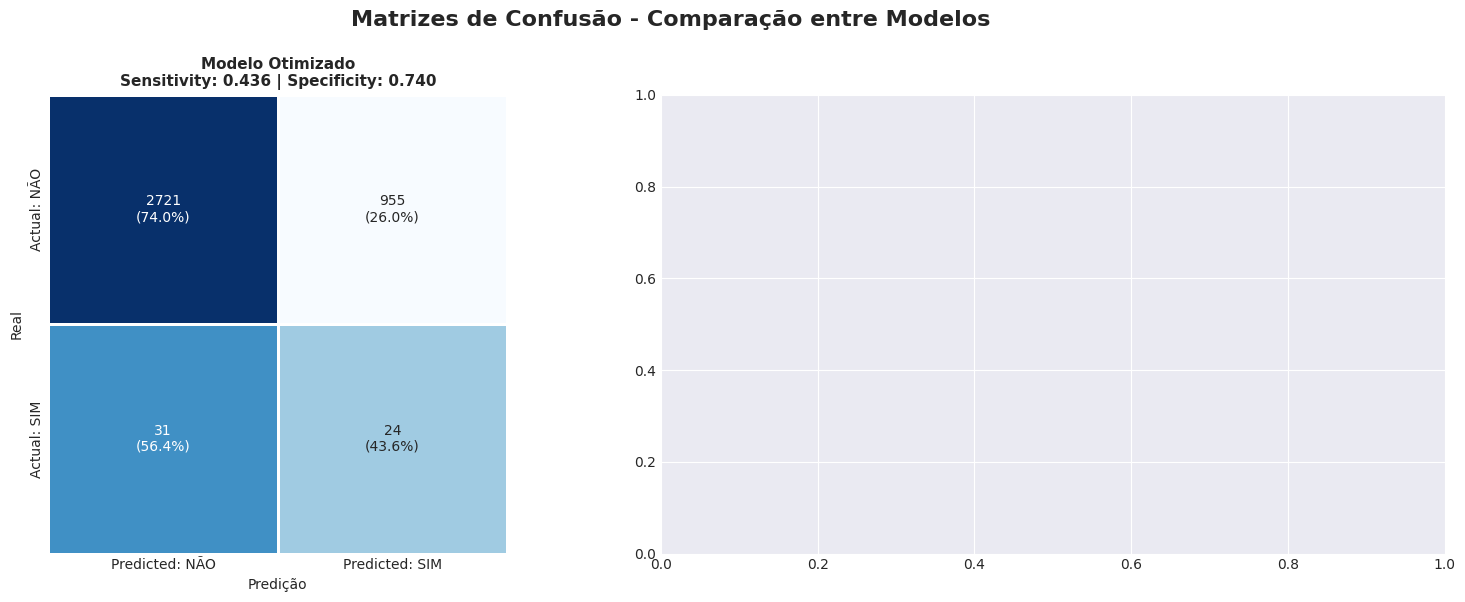

✅ Matrizes de Confusão salvas em 'viz_confusion_matrices.png'


In [35]:
# 3. CONFUSION MATRICES - Visualização para todos os modelos

print("\n" + "="*80)
print("📊 VISUALIZAÇÃO: MATRIZES DE CONFUSÃO")
print("="*80)

# -----------------------------------------------------------
# 1) Verificação básica: precisar ter pelo menos y_test
# -----------------------------------------------------------
required_vars = ['y_test']
missing = [var for var in required_vars if var not in globals()]

if missing:
    print("\n❌ ERRO: Esta célula requer variáveis que ainda não foram criadas:\n")
    for var in missing:
        print(f"  ❌ {var}")
    raise SystemExit("Dependências não satisfeitas (y_test ausente)")

y_test_array = np.asarray(y_test)

# -----------------------------------------------------------
# 2) Obter/Construir o dicionário `predictions`
# -----------------------------------------------------------
if 'predictions' in globals():
    if not isinstance(predictions, dict):
        raise TypeError("A variável 'predictions' existe, mas não é um dict.")
    print("✅ Usando dicionário 'predictions' já existente.")
else:
    print("\n⚠️ Variável 'predictions' não encontrada.")
    print("   Tentando construir as predições automaticamente a partir dos modelos...")

    # Candidatos comuns de X_test
    candidate_X = [
        'X_test_scaled',
        'X_test',
        'X_test_res',
        'X_test_smote',
    ]

    X_test_found = None
    X_test_name = None
    for name in candidate_X:
        if name in globals():
            X_test_found = globals()[name]
            X_test_name = name
            print(f"✅ Conjunto de teste encontrado: {name}")
            break

    if X_test_found is None:
        print("\n❌ Não foi possível encontrar X_test ou X_test_scaled.")
        print("   Verifique se alguma destas variáveis existe: "
              "X_test_scaled, X_test, X_test_res, X_test_smote.")
        raise SystemExit("Não foi possível construir 'predictions' automaticamente.")

    # Candidatos comuns de modelos (nomes de variáveis)
    candidate_models = [
        'best_model',
        'best_model_optuna',
        'log_reg_model',
        'log_reg_baseline',
        'rf_model',
        'random_forest_model',
        'xgb_model',
        'xgboost_model',
        'svc_model',
        'svm_model',
        'modelo_otimizado',
        'final_model',
    ]

    predictions = {}
    for var_name in candidate_models:
        if var_name in globals():
            model = globals()[var_name]
            if hasattr(model, 'predict'):
                try:
                    y_pred_model = model.predict(X_test_found)
                    pretty_name = var_name.replace('_', ' ').title()
                    predictions[pretty_name] = y_pred_model
                    print(f"✅ Modelo adicionado a 'predictions': {pretty_name} (variável: {var_name})")
                except Exception as e:
                    print(f"⚠️ Erro ao prever com o modelo '{var_name}': {e}")

    if not predictions:
        print("\n❌ Nenhum modelo com método .predict foi encontrado "
              "com os nomes esperados.")
        print("   Verifique os nomes das variáveis dos seus modelos "
              "e/ou defina manualmente o dicionário 'predictions'.")
        raise SystemExit("Não foi possível construir 'predictions' automaticamente.")

# -----------------------------------------------------------
# 3) Plotar as matrizes de confusão
# -----------------------------------------------------------
num_models = len(predictions)
grid_rows = int(np.ceil(num_models / 2))
fig, axes = plt.subplots(grid_rows, 2, figsize=(16, 6 * grid_rows))

# Se só tiver 1 linha, axes vem 1D; se tiver mais, vem 2D
if grid_rows == 1:
    axes = np.array(axes).reshape(-1)
else:
    axes = axes.ravel()

for i, (name, y_pred_model) in enumerate(predictions.items()):
    # Garante array numpy
    y_pred_model = np.asarray(y_pred_model)

    # Checagem de tamanho
    if y_pred_model.shape[0] != y_test_array.shape[0]:
        print(f"\n⚠️ Tamanho incompatível para o modelo '{name}': "
              f"y_pred = {y_pred_model.shape[0]}, y_test = {y_test_array.shape[0]}. "
              "Pulando este modelo.")
        continue

    cm = confusion_matrix(y_test_array, y_pred_model)

    # Normalizar para percentuais por linha
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Labels com contagem absoluta + percentual
    annotated = np.array([
        [f'{cm[0,0]}\n({cm_percent[0,0]:.1f}%)', f'{cm[0,1]}\n({cm_percent[0,1]:.1f}%)'],
        [f'{cm[1,0]}\n({cm_percent[1,0]:.1f}%)', f'{cm[1,1]}\n({cm_percent[1,1]:.1f}%)']
    ])

    ax = axes[i]

    sns.heatmap(
        cm_percent,
        annot=annotated,
        fmt='',
        cmap='Blues',
        square=True,
        linewidths=2,
        cbar=False,
        ax=ax,
        xticklabels=['Predicted: NÃO', 'Predicted: SIM'],
        yticklabels=['Actual: NÃO', 'Actual: SIM']
    )

    # Métricas adicionais
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
    specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0

    ax.set_title(
        f'{name}\nSensitivity: {sensitivity:.3f} | Specificity: {specificity:.3f}',
        fontsize=11,
        fontweight='bold'
    )
    ax.set_xlabel('Predição', fontsize=10)
    ax.set_ylabel('Real', fontsize=10)

plt.suptitle(
    'Matrizes de Confusão - Comparação entre Modelos',
    fontsize=16,
    fontweight='bold',
    y=0.995
)

plt.tight_layout()
plt.savefig('viz_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matrizes de Confusão salvas em 'viz_confusion_matrices.png'")




📊 VISUALIZAÇÃO: PRECISION-RECALL CURVES

⚠️ Variável 'probabilities' não encontrada.
   Tentando construir as probabilidades automaticamente a partir dos modelos...
✅ Conjunto de teste encontrado: X_test_scaled
✅ Modelo adicionado a 'probabilities': Modelo Otimizado (variável: modelo_otimizado)
✅ Dependências verificadas!


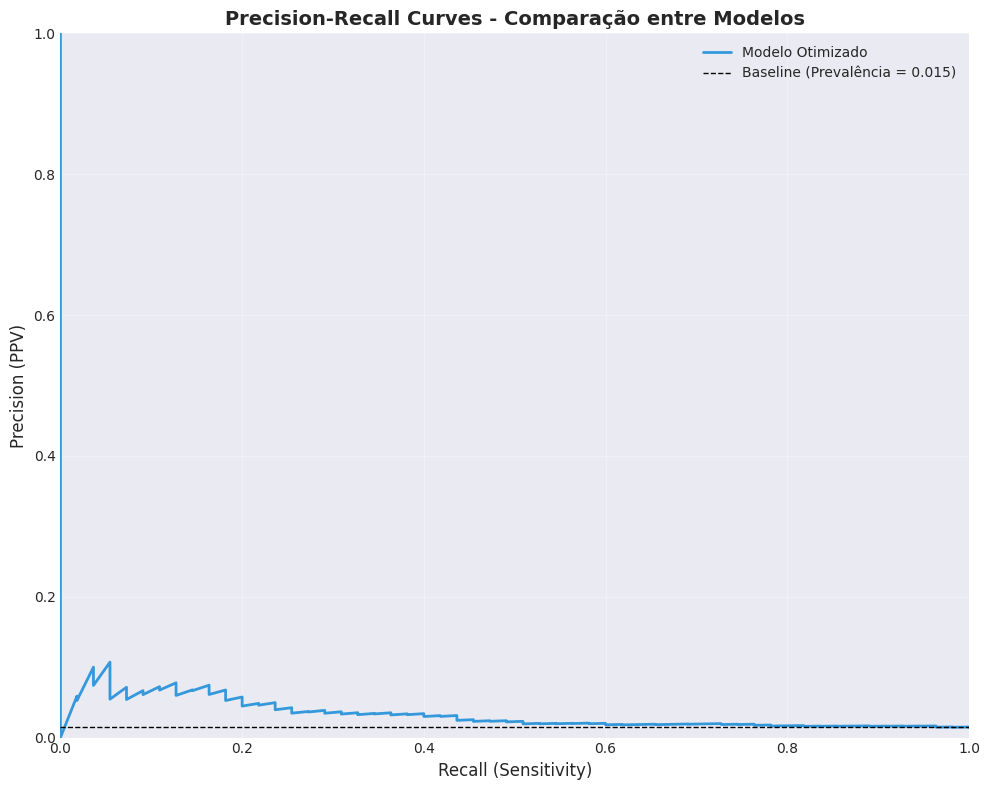

✅ Precision-Recall Curves salvas em 'viz_precision_recall_curves.png'


In [36]:
# 2. PRECISION-RECALL CURVES - Comparação entre Modelos

# -----------------------------------------------------------
# 1) Verificação básica: precisamos ter pelo menos y_test
# -----------------------------------------------------------
required_vars = ['y_test']
missing = [var for var in required_vars if var not in globals()]

if missing:
    print("\n❌ ERRO: Esta célula requer variáveis que ainda não foram criadas:")
    for var in missing:
        print(f"  ❌ {var}")
    raise SystemExit("Dependências não satisfeitas (y_test ausente)")

y_test_array = np.asarray(y_test)

print("\n" + "="*80)
print("📊 VISUALIZAÇÃO: PRECISION-RECALL CURVES")
print("="*80)

# -----------------------------------------------------------
# 2) Obter / construir o dicionário `probabilities`
# -----------------------------------------------------------
if 'probabilities' in globals():
    if not isinstance(probabilities, dict):
        raise TypeError("A variável 'probabilities' existe, mas não é um dict.")
    print("✅ Usando dicionário 'probabilities' já existente.")
else:
    print("\n⚠️ Variável 'probabilities' não encontrada.")
    print("   Tentando construir as probabilidades automaticamente a partir dos modelos...")

    # Candidatos comuns de X_test
    candidate_X = [
        'X_test_scaled',
        'X_test',
        'X_test_res',
        'X_test_smote',
    ]

    X_test_found = None
    X_test_name = None
    for name in candidate_X:
        if name in globals():
            X_test_found = globals()[name]
            X_test_name = name
            print(f"✅ Conjunto de teste encontrado: {name}")
            break

    if X_test_found is None:
        print("\n❌ Não foi possível encontrar X_test ou X_test_scaled.")
        print("   Verifique se alguma destas variáveis existe: "
              "X_test_scaled, X_test, X_test_res, X_test_smote.")
        raise SystemExit("Não foi possível construir 'probabilities' automaticamente.")

    # Candidatos comuns de modelos com predict_proba
    candidate_models = [
        'best_model',
        'best_model_optuna',
        'log_reg_model',
        'log_reg_baseline',
        'rf_model',
        'random_forest_model',
        'xgb_model',
        'xgboost_model',
        'svc_model',
        'svm_model',
        'modelo_otimizado',
        'final_model',
    ]

    probabilities = {}
    for var_name in candidate_models:
        if var_name in globals():
            model = globals()[var_name]
            if hasattr(model, 'predict_proba'):
                try:
                    y_proba_model = model.predict_proba(X_test_found)[:, 1]
                    pretty_name = var_name.replace('_', ' ').title()
                    probabilities[pretty_name] = y_proba_model
                    print(f"✅ Modelo adicionado a 'probabilities': {pretty_name} (variável: {var_name})")
                except Exception as e:
                    print(f"⚠️ Erro ao calcular probabilidades com o modelo '{var_name}': {e}")

    if not probabilities:
        print("\n❌ Nenhum modelo com método .predict_proba foi encontrado "
              "com os nomes esperados.")
        print("   Verifique os nomes das variáveis dos seus modelos "
              "e/ou defina manualmente o dicionário 'probabilities'.")
        raise SystemExit("Não foi possível construir 'probabilities' automaticamente.")

print("✅ Dependências verificadas!")

# -----------------------------------------------------------
# 3) Plot das curvas Precision-Recall
# -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))

# Gerar uma paleta de cores que suporte qualquer número de modelos
from itertools import cycle
color_cycle = cycle(['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f1c40f', '#1abc9c', '#34495e'])

for name, y_proba_model in probabilities.items():
    y_proba_model = np.asarray(y_proba_model)

    # Checagem de tamanho
    if y_proba_model.shape[0] != y_test_array.shape[0]:
        print(f"\n⚠️ Tamanho incompatível para o modelo '{name}': "
              f"y_proba = {y_proba_model.shape[0]}, y_test = {y_test_array.shape[0]}. "
              "Pulando este modelo.")
        continue

    precision, recall, _ = precision_recall_curve(y_test_array, y_proba_model)
    color = next(color_cycle)
    ax.plot(recall, precision, color=color, linewidth=2, label=name)

# Baseline (proporção da classe positiva)
baseline = y_test_array.sum() / len(y_test_array)
ax.plot([0, 1], [baseline, baseline], 'k--', linewidth=1,
        label=f'Baseline (Prevalência = {baseline:.3f})')

ax.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax.set_ylabel('Precision (PPV)', fontsize=12)
ax.set_title('Precision-Recall Curves - Comparação entre Modelos',
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('viz_precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Precision-Recall Curves salvas em 'viz_precision_recall_curves.png'")


📊 VISUALIZAÇÃO: CURVAS ROC
✅ Usando dicionário 'probabilities' já existente.
✅ Dependências verificadas!


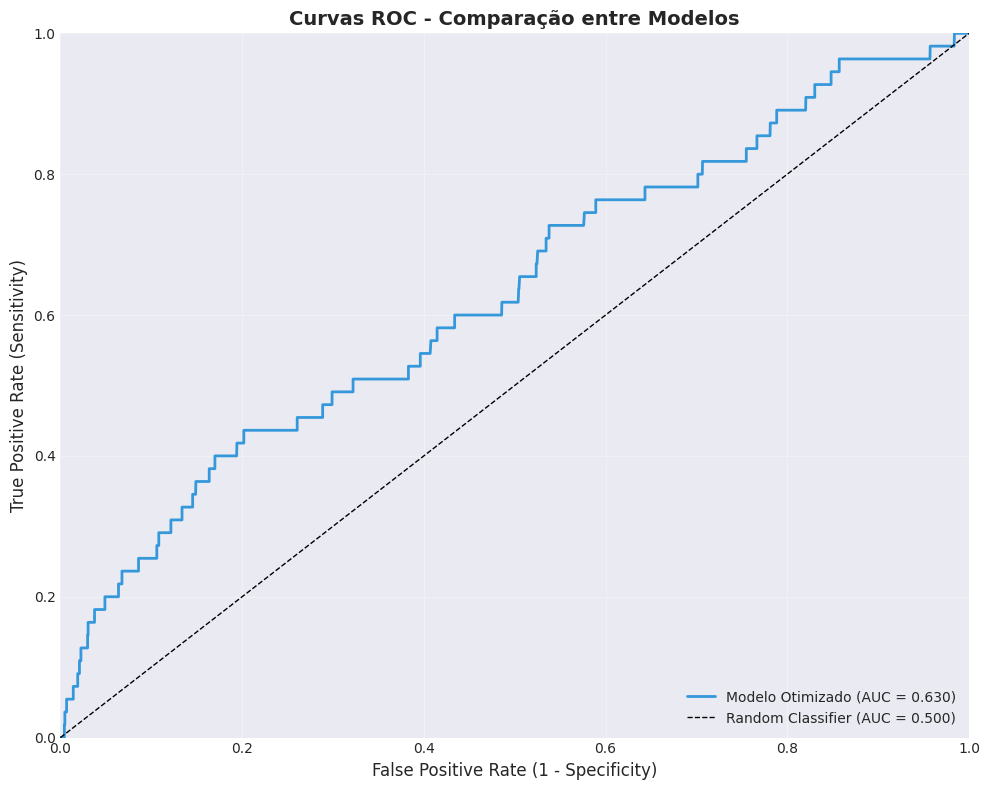

✅ Curvas ROC salvas em 'viz_roc_curves.png'


In [37]:
# 1. CURVAS ROC - Comparação entre Modelos

# -----------------------------------------------------------
# 1) Verificação básica: precisamos ter pelo menos y_test
# -----------------------------------------------------------
required_vars = ['y_test']
missing = [var for var in required_vars if var not in globals()]

if missing:
    print("\n❌ ERRO: Esta célula requer variáveis que ainda não foram criadas:")
    for var in missing:
        print(f"  ❌ {var}")
    raise SystemExit("Dependências não satisfeitas (y_test ausente)")

y_test_array = np.asarray(y_test)

print("="*80)
print("📊 VISUALIZAÇÃO: CURVAS ROC")
print("="*80)

# -----------------------------------------------------------
# 2) Obter / construir o dicionário `probabilities`
# -----------------------------------------------------------
if 'probabilities' in globals():
    if not isinstance(probabilities, dict):
        raise TypeError("A variável 'probabilities' existe, mas não é um dict.")
    print("✅ Usando dicionário 'probabilities' já existente.")
else:
    print("\n⚠️ Variável 'probabilities' não encontrada.")
    print("   Tentando construir as probabilidades automaticamente a partir dos modelos...")

    # Candidatos comuns de X_test
    candidate_X = [
        'X_test_scaled',
        'X_test',
        'X_test_res',
        'X_test_smote',
    ]

    X_test_found = None
    X_test_name = None
    for name in candidate_X:
        if name in globals():
            X_test_found = globals()[name]
            X_test_name = name
            print(f"✅ Conjunto de teste encontrado: {name}")
            break

    if X_test_found is None:
        print("\n❌ Não foi possível encontrar X_test ou X_test_scaled.")
        print("   Verifique se alguma destas variáveis existe: "
              "X_test_scaled, X_test, X_test_res, X_test_smote.")
        raise SystemExit("Não foi possível construir 'probabilities' automaticamente.")

    # Candidatos comuns de modelos com predict_proba
    candidate_models = [
        'best_model',
        'best_model_optuna',
        'log_reg_model',
        'log_reg_baseline',
        'rf_model',
        'random_forest_model',
        'xgb_model',
        'xgboost_model',
        'svc_model',
        'svm_model',
        'modelo_otimizado',
        'final_model',
    ]

    probabilities = {}
    for var_name in candidate_models:
        if var_name in globals():
            model = globals()[var_name]
            if hasattr(model, 'predict_proba'):
                try:
                    y_proba_model = model.predict_proba(X_test_found)[:, 1]
                    pretty_name = var_name.replace('_', ' ').title()
                    probabilities[pretty_name] = y_proba_model
                    print(f"✅ Modelo adicionado a 'probabilities': {pretty_name} (variável: {var_name})")
                except Exception as e:
                    print(f"⚠️ Erro ao calcular probabilidades com o modelo '{var_name}': {e}")

    if not probabilities:
        print("\n❌ Nenhum modelo com método .predict_proba foi encontrado "
              "com os nomes esperados.")
        print("   Verifique os nomes das variáveis dos seus modelos "
              "e/ou defina manualmente o dicionário 'probabilities'.")
        raise SystemExit("Não foi possível construir 'probabilities' automaticamente.")

print("✅ Dependências verificadas!")

# -----------------------------------------------------------
# 3) Plot das curvas ROC
# -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))

from itertools import cycle
color_cycle = cycle(['#3498db', '#2ecc71', '#e74c3c', '#9b59b6',
                     '#f1c40f', '#1abc9c', '#34495e'])

for name, y_proba_model in probabilities.items():
    y_proba_model = np.asarray(y_proba_model)

    # Checagem de tamanho
    if y_proba_model.shape[0] != y_test_array.shape[0]:
        print(f"\n⚠️ Tamanho incompatível para o modelo '{name}': "
              f"y_proba = {y_proba_model.shape[0]}, y_test = {y_test_array.shape[0]}. "
              "Pulando este modelo.")
        continue

    fpr, tpr, _ = roc_curve(y_test_array, y_proba_model)
    auc_score = roc_auc_score(y_test_array, y_proba_model)

    color = next(color_cycle)
    ax.plot(
        fpr,
        tpr,
        color=color,
        linewidth=2,
        label=f'{name} (AUC = {auc_score:.3f})'
    )

# Linha diagonal (classificador aleatório)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')

ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title('Curvas ROC - Comparação entre Modelos', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('viz_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas ROC salvas em 'viz_roc_curves.png'")


## 📈 10.5. VISUALIZAÇÕES DE AVALIAÇÃO

### Curvas ROC, Precision-Recall e Análise de Erros

   ⚠️ Não foi possível salvar 'optuna_history_logreg.png' porque o pacote 'kaleido' não está instalado.
      Se quiser salvar as imagens em arquivo, instale com:
      pip install -U kaleido


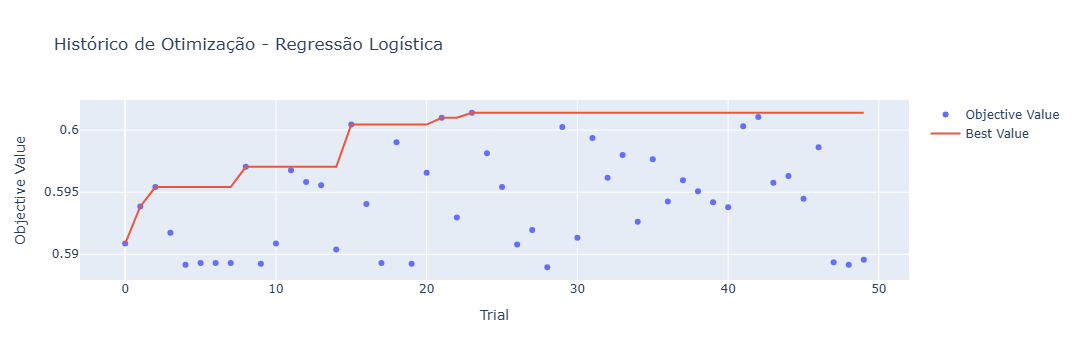

   ⚠️ Não foi possível salvar 'optuna_param_importance_logreg.png' porque o pacote 'kaleido' não está instalado.
      Se quiser salvar as imagens em arquivo, instale com:
      pip install -U kaleido


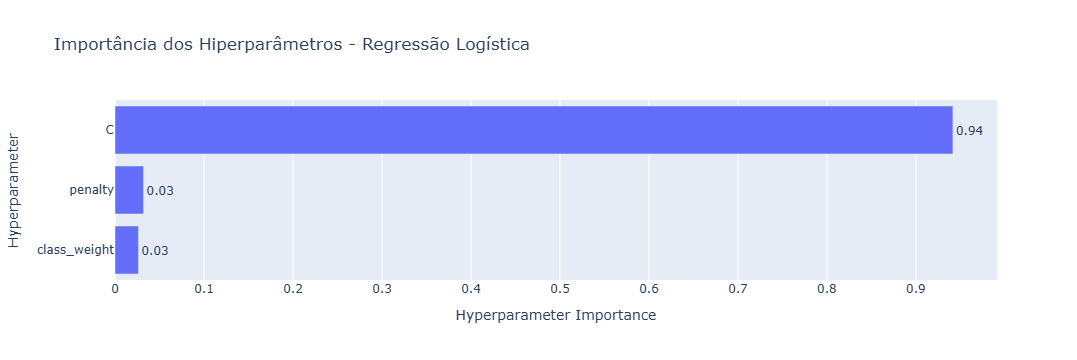


✅ Visualizações concluídas.
   (Se o pacote 'kaleido' não estiver instalado, as imagens não terão sido salvas em PNG.)


In [42]:
# Visualizar otimização (Optuna)

from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)

def tentar_salvar_figura(fig, filename, width=1200, height=600):
    """
    Tenta salvar a figura em arquivo PNG.
    Se o Kaleido não estiver instalado, apenas avisa e segue.
    """
    try:
        fig.write_image(filename, width=width, height=height)
        print(f"   ✅ Figura salva em: {filename}")
    except ValueError as e:
        # Erro típico quando o kaleido não está instalado
        if "kaleido" in str(e).lower():
            print(f"   ⚠️ Não foi possível salvar '{filename}' porque o pacote 'kaleido' não está instalado.")
            print("      Se quiser salvar as imagens em arquivo, instale com:")
            print("      pip install -U kaleido")
        else:
            print(f"   ⚠️ Erro ao salvar '{filename}': {e}")

# -----------------------------------------------------------------------------
# Histórico de otimização
# -----------------------------------------------------------------------------
fig = plot_optimization_history(study_logreg)
fig.update_layout(title='Histórico de Otimização - Regressão Logística')

tentar_salvar_figura(fig, 'optuna_history_logreg.png', width=1200, height=600)
fig.show()

# -----------------------------------------------------------------------------
# Importância dos hiperparâmetros
# -----------------------------------------------------------------------------
fig = plot_param_importances(study_logreg)
fig.update_layout(title='Importância dos Hiperparâmetros - Regressão Logística')

tentar_salvar_figura(fig, 'optuna_param_importance_logreg.png', width=1000, height=600)
fig.show()

print("\n✅ Visualizações concluídas.")
print("   (Se o pacote 'kaleido' não estiver instalado, as imagens não terão sido salvas em PNG.)")


## 🤖 9. TREINAMENTO FINAL COM HIPERPARÂMETROS OTIMIZADOS

In [43]:
print("="*80)
print("🤖 TREINAMENTO FINAL COM HIPERPARÂMETROS OTIMIZADOS")
print("="*80)

# Modelo otimizado
best_params_logreg = study_logreg.best_params
best_params_logreg['solver'] = 'saga'
best_params_logreg['max_iter'] = 2000
best_params_logreg['random_state'] = RANDOM_STATE

modelo_otimizado = LogisticRegression(**best_params_logreg)

print("\n🔄 Treinando Regressão Logística Otimizada...")
modelo_otimizado.fit(X_train_balanced, y_train_balanced)

# Predições
y_pred = modelo_otimizado.predict(X_test_scaled)
y_proba = modelo_otimizado.predict_proba(X_test_scaled)[:, 1]

print("✅ Modelo otimizado treinado!")

🤖 TREINAMENTO FINAL COM HIPERPARÂMETROS OTIMIZADOS

🔄 Treinando Regressão Logística Otimizada...
✅ Modelo otimizado treinado!


In [44]:
# Treinar modelos de comparação (sem tunagem)
print("\n🔄 Treinando modelos de comparação...\n")

comparison_models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, max_depth=15),
    'XGBoost': XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, max_depth=6, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=200, random_state=RANDOM_STATE, verbose=0)
}

trained_models = {'Logistic Regression (Optuna)': modelo_otimizado}
predictions = {'Logistic Regression (Optuna)': y_pred}
probabilities = {'Logistic Regression (Optuna)': y_proba}

for name, model in comparison_models.items():
    print(f"   Treinando {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    
    trained_models[name] = model
    predictions[name] = model.predict(X_test_scaled)
    probabilities[name] = model.predict_proba(X_test_scaled)[:, 1]

print("\n✅ Todos os modelos treinados!")


🔄 Treinando modelos de comparação...

   Treinando Random Forest...
   Treinando XGBoost...
   Treinando CatBoost...

✅ Todos os modelos treinados!


## 📊 10. AVALIAÇÃO CLÍNICA COMPLETA

In [47]:
def evaluate_clinical_model(y_true, y_pred, y_proba, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f"""
    ╔══════════════════════════════════════════════════╗
    ║  {model_name:<46s}║
    ╚══════════════════════════════════════════════════╝
    
    📊 Confusion Matrix:
       TN: {tn:>5}  |  FP: {fp:>5}
       FN: {fn:>5}  |  TP: {tp:>5}
    
    🎯 Métricas:
       Accuracy:    {accuracy:.4f}
       Sensitivity: {sensitivity:.4f}  ⭐ CRÍTICO
       Specificity: {specificity:.4f}
       PPV:         {ppv:.4f}
       NPV:         {npv:.4f}
       F1-Score:    {f1:.4f}
       ROC-AUC:     {auc:.4f}
    
    ⚠️  Falsos Negativos: {fn} pacientes graves NÃO detectados
    """)
    
    return {
        'model': model_name,
        'accuracy': accuracy, 'sensitivity': sensitivity,
        'specificity': specificity, 'ppv': ppv, 'npv': npv,
        'f1': f1, 'auc': auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }

# Avaliar todos
print("="*80)
print("📊 AVALIAÇÃO CLÍNICA DE TODOS OS MODELOS")
print("="*80)

results = []
for name in trained_models.keys():
    result = evaluate_clinical_model(y_test, predictions[name], probabilities[name], name)
    results.append(result)

results_df = pd.DataFrame(results).sort_values('sensitivity', ascending=False)

print("\n" + "="*80)
print("📊 RESUMO COMPARATIVO")
print("="*80)
print(results_df[['model', 'sensitivity', 'specificity', 'ppv', 'npv', 'f1', 'auc']].to_string(index=False))

📊 AVALIAÇÃO CLÍNICA DE TODOS OS MODELOS

    ╔══════════════════════════════════════════════════╗
    ║  Logistic Regression (Optuna)                  ║
    ╚══════════════════════════════════════════════════╝

    📊 Confusion Matrix:
       TN:  2721  |  FP:   955
       FN:    31  |  TP:    24

    🎯 Métricas:
       Accuracy:    0.7357
       Sensitivity: 0.4364  ⭐ CRÍTICO
       Specificity: 0.7402
       PPV:         0.0245
       NPV:         0.9887
       F1-Score:    0.0464
       ROC-AUC:     0.6295

    ⚠️  Falsos Negativos: 31 pacientes graves NÃO detectados
    

    ╔══════════════════════════════════════════════════╗
    ║  Random Forest                                 ║
    ╚══════════════════════════════════════════════════╝

    📊 Confusion Matrix:
       TN:  3623  |  FP:    53
       FN:    50  |  TP:     5

    🎯 Métricas:
       Accuracy:    0.9724
       Sensitivity: 0.0909  ⭐ CRÍTICO
       Specificity: 0.9856
       PPV:         0.0862
       NPV:         0.9864

## 💾 11. SALVAR MODELO FINAL

In [46]:
print("="*80)
print("💾 SALVANDO MODELO E ARTEFATOS")
print("="*80)

# Melhor modelo
best_model_name = results_df.iloc[0]['model']
best_model = trained_models[best_model_name]

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"   Sensitivity: {results_df.iloc[0]['sensitivity']:.4f}")
print(f"   ROC-AUC: {results_df.iloc[0]['auc']:.4f}")

# Salvar modelo
joblib.dump(best_model, 'modelo_reglog_otimizado.pkl')
joblib.dump(scaler_final, 'scaler_final.pkl')

# Salvar features
with open('features_selecionadas.txt', 'w') as f:
    for feat in selected_feature_names:
        f.write(f"{feat}\n")

# Configuração completa
config = {
    'modelo': best_model_name,
    'features_total': len(feature_cols_original),
    'features_selecionadas': len(selected_feature_names),
    'features': selected_feature_names,
    'hiperparametros_otuna': study_logreg.best_params,
    'metricas': results_df.iloc[0].to_dict(),
    'data_treinamento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_state': RANDOM_STATE
}

with open('config_modelo.json', 'w') as f:
    json.dump(config, f, indent=4)

# Salvar estudo Optuna
joblib.dump(study_logreg, 'optuna_study_logreg.pkl')

print("\n✅ Artefatos salvos:")
print("   - modelo_reglog_otimizado.pkl")
print("   - scaler_final.pkl")
print("   - features_selecionadas.txt")
print("   - config_modelo.json")
print("   - optuna_study_logreg.pkl")

💾 SALVANDO MODELO E ARTEFATOS

🏆 MELHOR MODELO: Logistic Regression (Optuna)
   Sensitivity: 0.4364
   ROC-AUC: 0.6295

✅ Artefatos salvos:
   - modelo_reglog_otimizado.pkl
   - scaler_final.pkl
   - features_selecionadas.txt
   - config_modelo.json
   - optuna_study_logreg.pkl


## 📝 12. RESUMO FINAL

In [48]:
print("="*90)
print("📊 RESUMO EXECUTIVO FINAL - MODELO DE PREDIÇÃO DE HOSPITALIZAÇÃO POR DENGUE")
print("="*90)

print("\n🎯 OBJETIVO ATENDIDO:")
print("   ✅ Características Demográficas: IDADE, SEXO, RAÇA")
print("   ✅ Sintomas Clínicos: FEBRE, MIALGIA, CEFALEIA, VOMITO, EXANTEMA (5 principais OMS)")
print("   ✅ Condições Climáticas: FENOMENO, INTENS_FENOM, MES (sazonalidade)")

print("\n📊 DATASET:")
print(f"   Total de registros: {len(df):,}")
print(f"   Treino/Teste: 80/20 (estratificado, random_state=42)")
print(f"   Balanceamento: SMOTE")
print(f"   Registros balanceados: {len(y_train_balanced):,}")

print("\n🔧 METODOLOGIA:")
print(f"   Algoritmo Principal: Regressão Logística (otimizada com Optuna)")
print(f"   Features Originais: {len(feature_cols_original)}")
print(f"   Features Selecionadas: {len(selected_feature_names)} (redução de {(1-len(selected_feature_names)/len(feature_cols_original))*100:.1f}%)")
print(f"   Pré-processamento: One-Hot Encoding, StandardScaler, SMOTE")
print(f"   Tunagem: Optuna (50 trials, 5-fold CV)")

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"\n📈 MÉTRICAS:")
for metric in ['sensitivity', 'specificity', 'ppv', 'npv', 'f1', 'auc']:
    value = results_df.iloc[0][metric]
    star = '  ⭐ PRIORITÁRIO' if metric == 'sensitivity' else ''
    print(f"   {metric.upper():<12s}: {value:.4f}{star}")

print(f"\n⚠️  ANÁLISE DE ERROS:")
print(f"   Falsos Negativos: {int(results_df.iloc[0]['fn'])} (pacientes graves NÃO detectados)")
print(f"   Falsos Positivos: {int(results_df.iloc[0]['fp'])} (alertas desnecessários)")

print(f"\n🔧 HIPERPARÂMETROS OTIMIZADOS (Optuna):")
for param, value in study_logreg.best_params.items():
    print(f"   {param}: {value}")

print(f"\n✅ FEATURES SELECIONADAS ({len(selected_feature_names)}):")
for i, feat in enumerate(selected_feature_names, 1):
    print(f"   {i:2d}. {feat}")

print("\n" + "="*90)
print("✅ MODELO PRONTO PARA DEPLOY!")
print("="*90)

print("\n🚀 PRÓXIMOS PASSOS:")
print("   1. Validação clínica com especialistas")
print("   2. Testes em dados novos (validação temporal)")
print("   3. Deploy em API (FastAPI/Flask)")
print("   4. Dashboard para equipe médica")
print("   5. Monitoramento contínuo e retraining")

print("\n🏥 Healthcare ML: Recall > tudo. Melhor errar por excesso de cuidado!")

📊 RESUMO EXECUTIVO FINAL - MODELO DE PREDIÇÃO DE HOSPITALIZAÇÃO POR DENGUE

🎯 OBJETIVO ATENDIDO:
   ✅ Características Demográficas: IDADE, SEXO, RAÇA
   ✅ Sintomas Clínicos: FEBRE, MIALGIA, CEFALEIA, VOMITO, EXANTEMA (5 principais OMS)
   ✅ Condições Climáticas: FENOMENO, INTENS_FENOM, MES (sazonalidade)

📊 DATASET:
   Total de registros: 18,653
   Treino/Teste: 80/20 (estratificado, random_state=42)
   Balanceamento: SMOTE
   Registros balanceados: 29,408

🔧 METODOLOGIA:
   Algoritmo Principal: Regressão Logística (otimizada com Optuna)
   Features Originais: 23
   Features Selecionadas: 14 (redução de 39.1%)
   Pré-processamento: One-Hot Encoding, StandardScaler, SMOTE
   Tunagem: Optuna (50 trials, 5-fold CV)

🏆 MELHOR MODELO: Logistic Regression (Optuna)

📈 MÉTRICAS:
   SENSITIVITY : 0.4364  ⭐ PRIORITÁRIO
   SPECIFICITY : 0.7402
   PPV         : 0.0245
   NPV         : 0.9887
   F1          : 0.0464
   AUC         : 0.6295

⚠️  ANÁLISE DE ERROS:
   Falsos Negativos: 31 (pacientes g